In [4]:
import imports
# 允许多行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

ImportError: cannot import name __check_build

In [261]:
# 导入数据
path = './csvs/pms_dfqp_lda_7days.csv'
columns = [
'fuid',  
'fplatformname',  
'label_score', 
'lifespan', 
'signup_to_now_days', 
'total_silver_coin', 
'total_gold_bar',  
'carrying_silver_coin',  
'carrying_gold_bar',  
'safebox_silver_coin',  
'safebox_gold_bar',  
'if_vip', 
'play_duration_life', 
'play_duration_30day', 
'play_duration_7day', 
'play_innings_life', 
'play_innings_30day', 
'play_innings_7day', 
'win_innings_life', 
'win_innings_7day', 
'lose_innings_life', 
'lose_innings_7day', 
'win_rate_life', 
'win_rate_7day', 
'pay_count_life', 
'pay_count_30day', 
'pay_count_7day', 
'pay_sum_life', 
'pay_sum_30day', 
'pay_sum_7day', 
'login_count_life', 
'login_count_7day', 
'bankrupt_count_life', 
'bankrupt_count_7day', 
'relieve_count_life', 
'relieve_silver_coins_life',  
'match_innings_life', 
'match_duration_life', 
'match_win_rate_life',
'recent_login_series_days', 
'latest_play_coins_win',
'latest_play_coins_lose',  
'last_active_to_now_days', 
'last_pay_to_now_days', 
'if_away', 
'dt',
]

data = pd.read_csv(path,names=columns,skiprows=1)
names =data.iloc[:,2:44].columns
data.groupby('if_away').size()
#data.head(10)

if_away
0    7618
1    2382
dtype: int64

### 不平衡分类的问题
从是否流失来看，两者比例大概为8:2，可见这是一个不平衡的分类问题，由于我们想知道的是：<b>有多少真正流失的用户被预测为流失</b>，那么我们应该使用的是召回率"Recall" $TP/(TP+FN)$

In [404]:
# 封装算法，画出算法分数箱线图
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score
def algorithm(X,y,score):
    num_folds = 10
    scoring = score
    seed = 7
    kfold = KFold(n_splits=num_folds,random_state=seed)
    results = []
    

    ## 普通算法
    models = {}
    # 逻辑回归
    models['LR'] = LogisticRegression()
    # 线性判别分析
    models['LDA'] = LinearDiscriminantAnalysis()
    # K近邻
    models['KNN'] = KNeighborsClassifier()
    # 分类与回归树
    models['CART'] = DecisionTreeClassifier()
    # 贝叶斯分类器
    models['NB'] = GaussianNB()
    # 支持向量机
    models['SVM'] = SVC()
    
    for key in models:
        cv_results = cross_val_score(models[key],X,y,cv=kfold,scoring=scoring)
        results.append(cv_results)
        print('%s: %f (%f)'% (key,cv_results.mean(),cv_results.std()))
        
    ## 集成算法
    ensembles = {}
    ensembles['ScaledAB'] = Pipeline([('Scaler',StandardScaler()),('AB',AdaBoostClassifier())])
    ensembles['ScaledGBM'] = Pipeline([('Scaler',StandardScaler()),('GBM',GradientBoostingClassifier())])
    ensembles['ScaledRF'] = Pipeline([('Scaler',StandardScaler()),('RFR',RandomForestClassifier())])
    ensembles['ScaledET'] = Pipeline([('Scaler',StandardScaler()),('ETR',ExtraTreesClassifier())])
  
    for key in ensembles:
        cv_result = cross_val_score(ensembles[key],X,y,cv=kfold,scoring=scoring)
        results.append(cv_result)
        print('%s: %f (%f)'% (key,cv_result.mean(),cv_result.std()))
        
    # 通过箱线图显示数据的分布情况
    fig = plt.figure(figsize=(18, 8), dpi=200)
    ax = fig.add_subplot(111)
    plt.boxplot(results);
    ax.set_xticklabels(models.keys()+ensembles.keys());
    
"""
    c_models = []
    model_logistic = LogisticRegression()
    model_cart = DecisionTreeClassifier()
    model_LDA = LinearDiscriminantAnalysis()
    model_KNN = KNeighborsClassifier()
    model_NB = GaussianNB()
    model_SVM = SVC(probability=True)
    c_models.append(('lr',model_logistic))
    c_models.append(('cart',model_cart))
    c_models.append(('lda',model_LDA))
    c_models.append(('knn',model_KNN))
    c_models.append(('nb',model_NB))
    c_models.append(('svm',model_SVM))
    ensemble_model = {}
    ensemble_model['Voting'] = VotingClassifier(estimators=c_models)
    ensemble_model_result = cross_val_score(ensemble_model,X,y,cv=kfold,scoring=scoring)
    results.append(ensemble_model_result)
    print('%s: %f (%f)'% (key,ensemble_model_result.mean(),ensemble_model_result.std()))
    if score == 'roc_auc':
        ensemble_model['Voting'] = VotingClassifier(estimators=c_models,voting='soft')
        ensemble_model['Voting'].fit(X,y)
        print('%s:%f'%('voting',roc_auc_score(y, ensemble_model[key].predict_proba(X)[:,1],average='macro')))
    else:
        ensemble_model['Voting'] = VotingClassifier(estimators=c_models)
        print ensemble_model
        #ensemble_model['Voting'].fit(X,y)
        ensemble_model_result = cross_val_score(ensemble_model,X,y,cv=kfold,scoring=scoring)
        print ensemble_model_result
        results.append(ensemble_model_result)
        print('%s: %f (%f)'% (key,ensemble_model_result.mean(),ensemble_model_result.std()))
"""

"\n    c_models = []\n    model_logistic = LogisticRegression()\n    model_cart = DecisionTreeClassifier()\n    model_LDA = LinearDiscriminantAnalysis()\n    model_KNN = KNeighborsClassifier()\n    model_NB = GaussianNB()\n    model_SVM = SVC(probability=True)\n    c_models.append(('lr',model_logistic))\n    c_models.append(('cart',model_cart))\n    c_models.append(('lda',model_LDA))\n    c_models.append(('knn',model_KNN))\n    c_models.append(('nb',model_NB))\n    c_models.append(('svm',model_SVM))\n    ensemble_model = {}\n    ensemble_model['Voting'] = VotingClassifier(estimators=c_models)\n    ensemble_model_result = cross_val_score(ensemble_model,X,y,cv=kfold,scoring=scoring)\n    results.append(ensemble_model_result)\n    print('%s: %f (%f)'% (key,ensemble_model_result.mean(),ensemble_model_result.std()))\n    if score == 'roc_auc':\n        ensemble_model['Voting'] = VotingClassifier(estimators=c_models,voting='soft')\n        ensemble_model['Voting'].fit(X,y)\n        print('%s

### 先选择全部特征测试模型

In [263]:
from sklearn.preprocessing import MinMaxScaler
array= data.values
X = array[:,2:44].astype(np.float32)
y = array[:,44].astype(np.float32)
# 调整数据尺度
transformer = MinMaxScaler(feature_range=(0,1))
newX = transformer.fit_transform(X)

In [264]:
validation_size = 0.2
seed = 7
X_t,X_v,y_t,y_v = train_test_split(newX,y,test_size=validation_size,random_state=seed)

KNN: 0.457871 (0.017709)
LDA: 0.441812 (0.033175)
SVM: 0.391750 (0.024913)
NB: 0.924059 (0.024052)
CART: 0.506985 (0.019927)
LR: 0.429316 (0.028895)
ScaledET: 0.393306 (0.033321)
ScaledAB: 0.537904 (0.018621)
ScaledRF: 0.416523 (0.025672)
ScaledGBM: 0.545401 (0.016347)


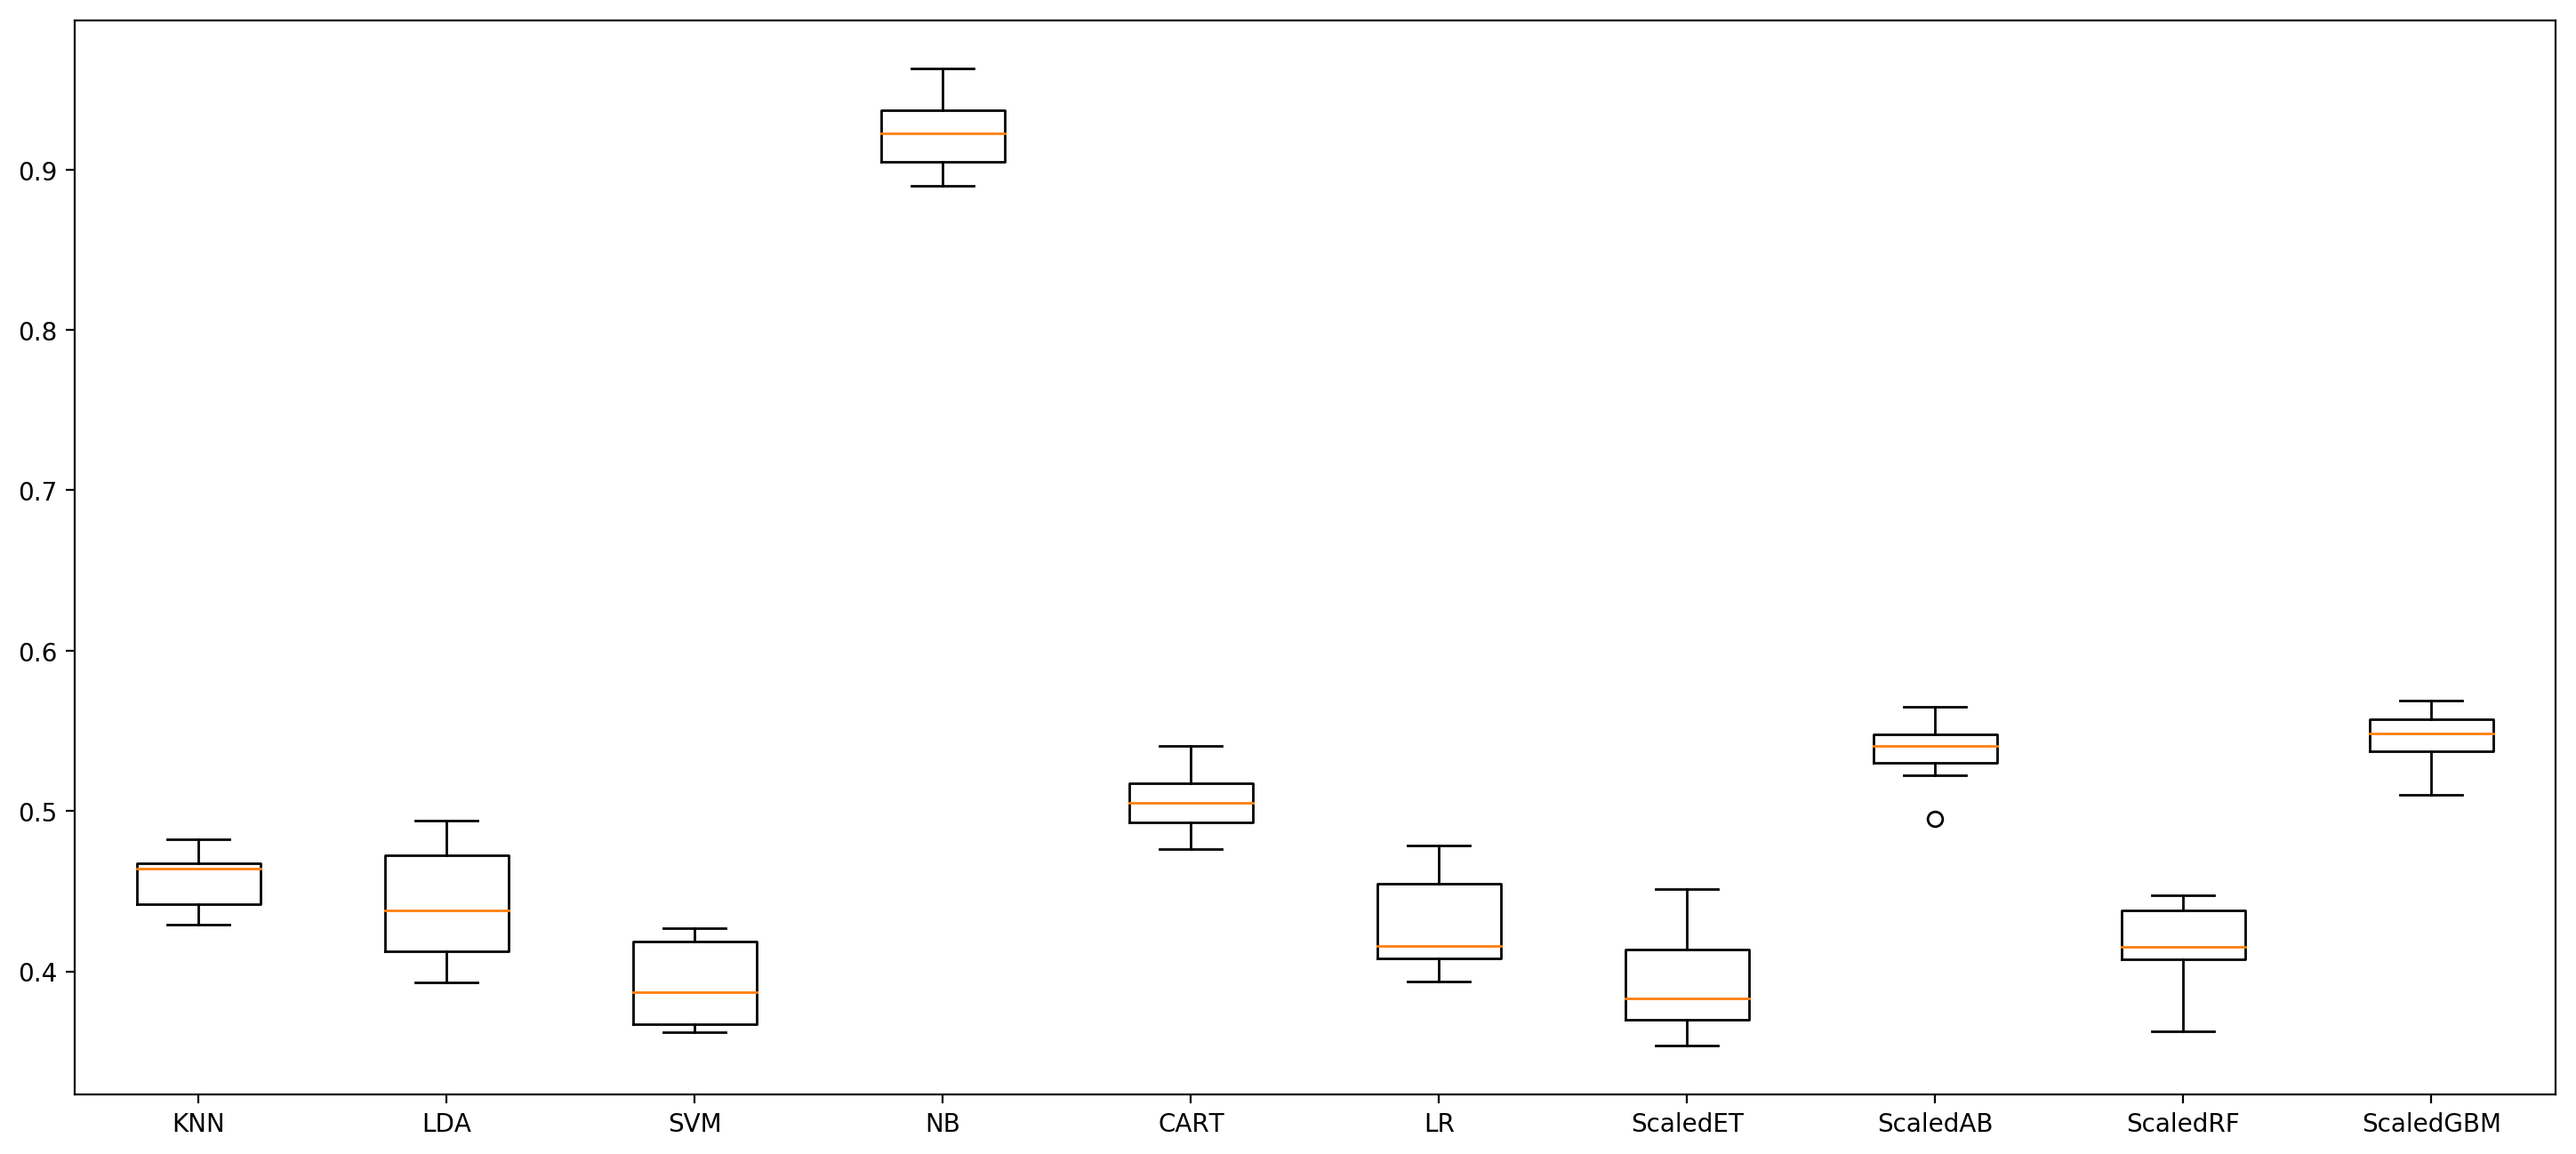

In [402]:
algorithm(X_t,y_t,"recall")

KNN: 0.560450 (0.044076)
LDA: 0.618041 (0.031737)
SVM: 0.623343 (0.034822)
NB: 0.358627 (0.022519)
CART: 0.488459 (0.025228)
LR: 0.644427 (0.032465)
ScaledET: 0.615639 (0.032540)
ScaledAB: 0.624435 (0.036143)
ScaledRF: 0.604466 (0.026807)
ScaledGBM: 0.632833 (0.030092)


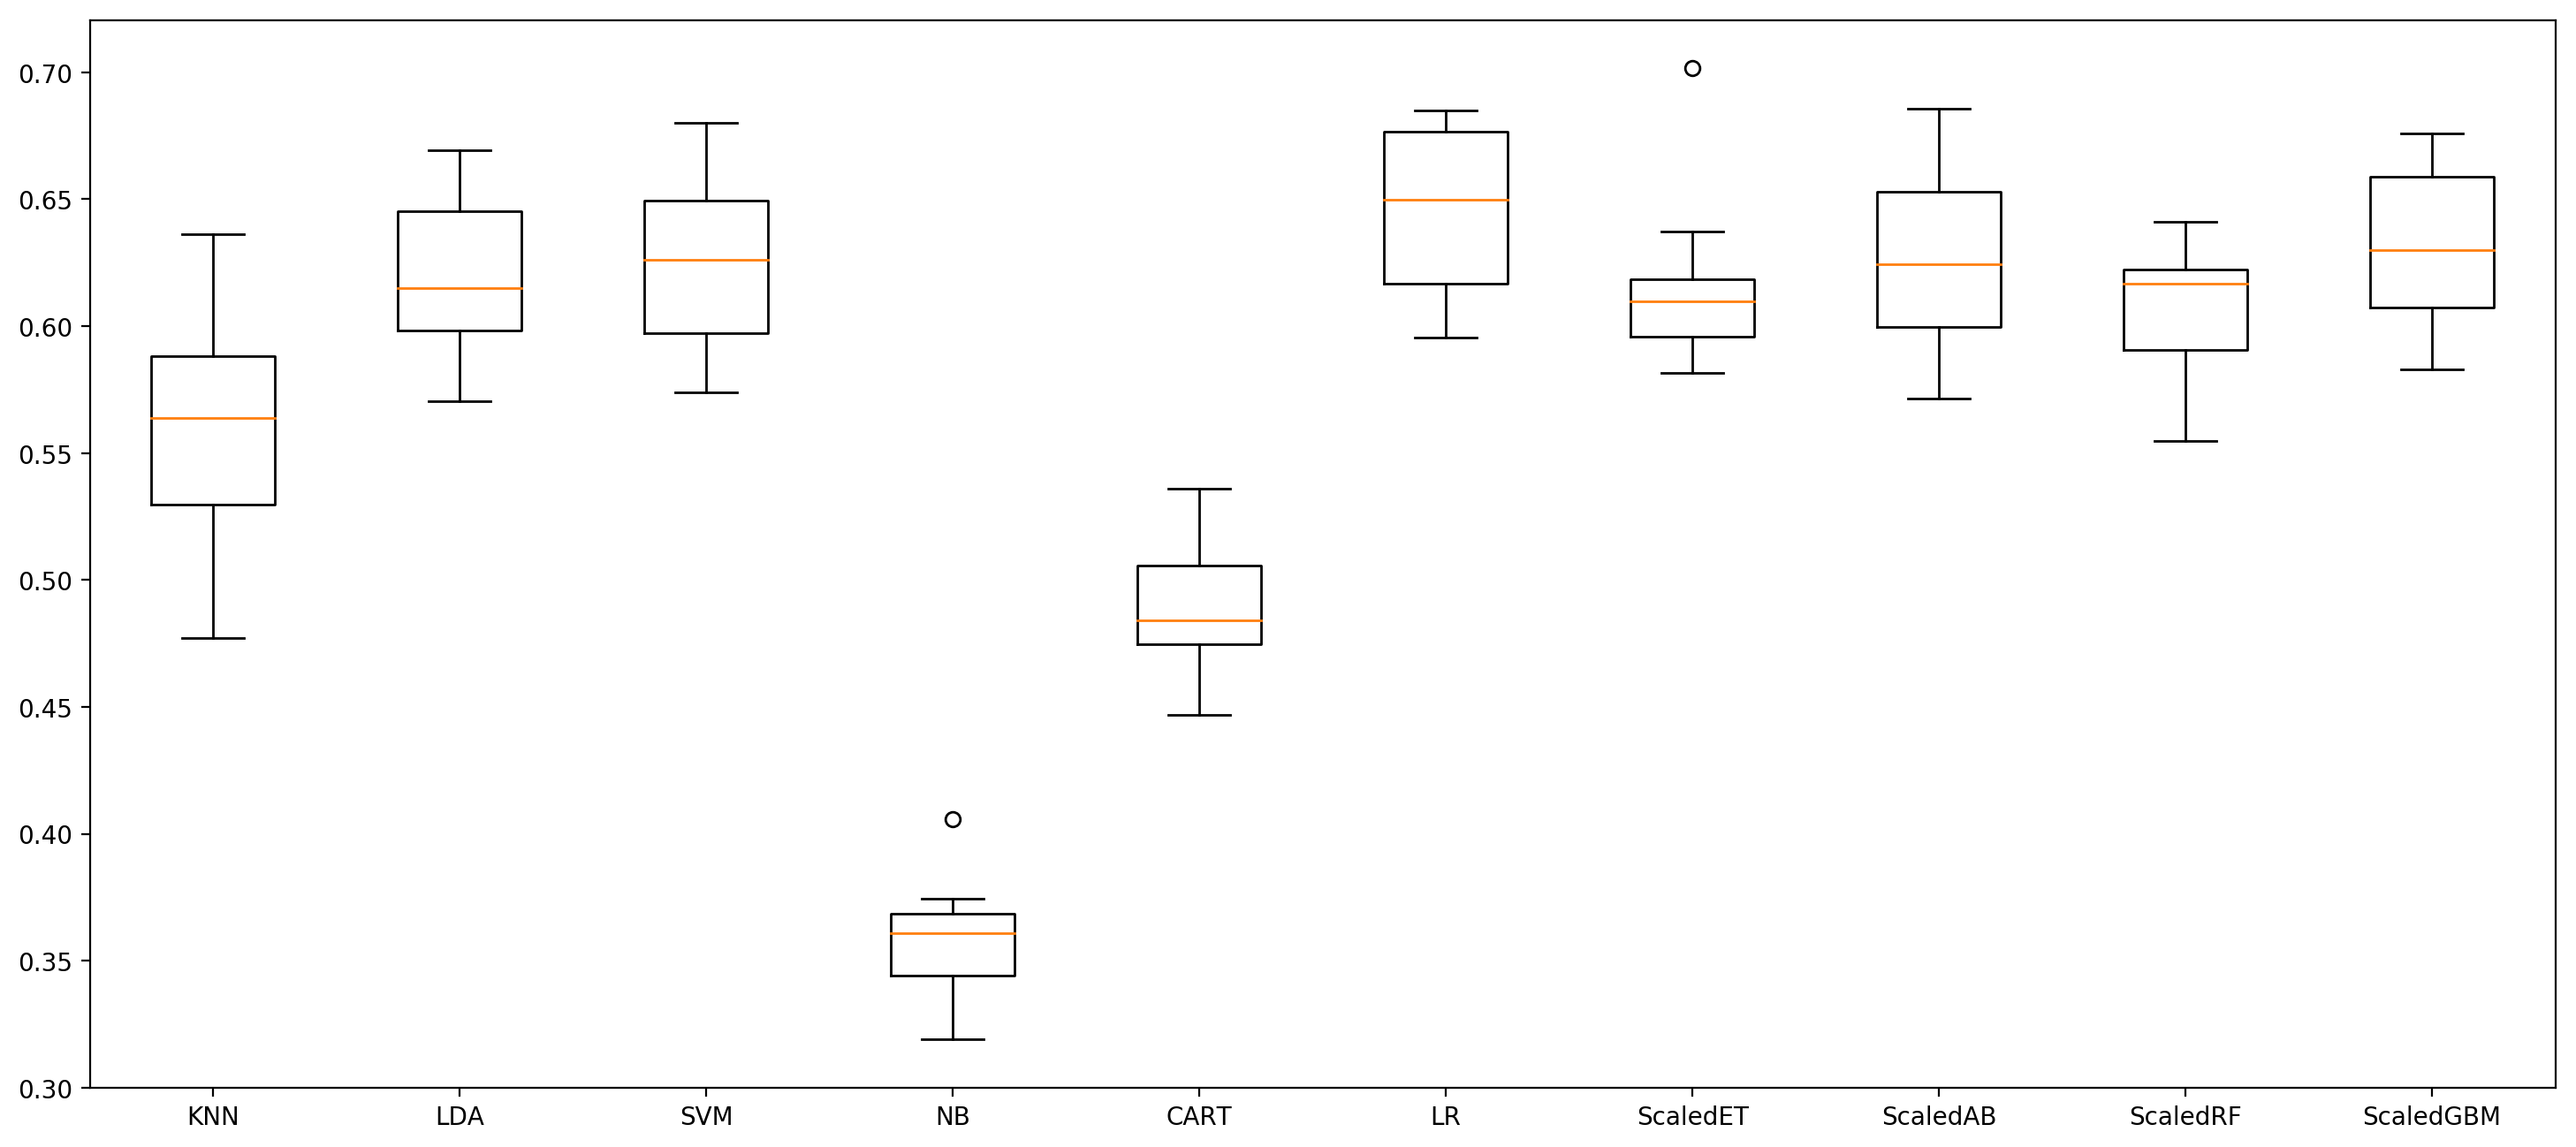

In [403]:
algorithm(X_t,y_t,"precision")

### 从结果来看，选择全部特征的时候，贝叶斯分类器（GaussianNB）的recall分值达到了惊人的92%

In [266]:
NB = GaussianNB()
NB.fit(X_t1,y_t1)
cross_val_score(model, X_v, y_v, scoring='recall')

GaussianNB(priors=None)

array([ 0.91946309,  0.91275168,  0.91946309])

#### 测试数据也达到了相当高的分数

### <span style="color:red">有没有可能是因为模型把本来没有流失的用户也预测为流失，导致结果偏高呢？</span>
我们导出预测数据看看

In [195]:
predict_y = model.predict(X_v)
if_away = y_v
result = pd.DataFrame({'if_away_true':if_away,'predict_result':predict_y})
result_name = './2018_07_24_result.csv'
result.to_csv(result_name)

<img src="./if_awy.png" />

#### 从结果来看，预测为流失的，实际未流失的人数有805人，所以才导致模型的recall分值高
### 我们用全部的数据跑一遍模型，看看是否和用户分值相关

In [212]:
# 使用全部数据
predict_y = model.predict(newX)
if_away = y
label_score = data['label_score']
result = pd.DataFrame({'if_away_true':if_away,'predict_result':predict_y,'label_score':label_score})
result_name = './2018_07_24_result2.csv'
result.to_csv(result_name)

<img src='./predict-2.png' />

#### 可见，模型预测的时候，对于高分值段用户的流失准确性很低，大部分都没有预测到其流失，并且把很多并没有流失的用户判定为流失，并且比例还不低，这样的结果并不是我们想要的
## 然后，要怎么办呢？
# 当然是增加特征！！
#### 从特征分值那里可以看出，label_score的分值总体很高，不过我们这里定义的用户分值是从整个用户的生命周期来定义的，参考马尔科夫过程，我们猜测用户下一周是否流失依赖上一周的用户价值分，所以我们增加两项特征：用户本周的价值分--label_score_week和用户最近30天的价值分--label_score_month
为了能够公平地比较，我们采用同一套数据

In [249]:
data_addition_feature = pd.read_csv('./csvs/pms_dfqp_lda_7days_addition.csv')
data_addition_feature.fillna(0,inplace=True)
data_new = pd.merge(data,data_addition_feature,left_on='fuid',right_on='mid')
data_new.drop(['mid','dt'],axis=1,inplace=True)
new_columns = ['fuid','fplatformname','if_away','label_score','lifespan',
      'signup_to_now_days','total_silver_coin','total_gold_bar',
      'carrying_silver_coin','carrying_gold_bar','safebox_silver_coin',
      'safebox_gold_bar','if_vip','play_duration_life',
      'play_duration_30day','play_duration_7day','play_innings_life',
      'play_innings_30day','play_innings_7day','win_innings_life',
      'win_innings_7day','lose_innings_life','lose_innings_7day',
      'win_rate_life','win_rate_7day','pay_count_life',
      'pay_count_30day','pay_count_7day','pay_sum_life',
      'pay_sum_30day','pay_sum_7day','login_count_life',
      'login_count_7day','bankrupt_count_life','bankrupt_count_7day',
      'relieve_count_life','relieve_silver_coins_life',
      'match_innings_life','match_duration_life','match_win_rate_life',
      'recent_login_series_days','latest_play_coins_win',
      'latest_play_coins_lose','last_active_to_now_days',
      'last_pay_to_now_days','play_passion_7days',
      'pay_passion_7days','label_score_7days','play_passion_30days',
      'pay_passion_30days','label_score_30days']
data_new = data_new[new_columns]
#data_new.head(10)

In [234]:
array_add= data_new.values
X_add = array_add[:,3:52].astype(np.float32)
y_add = array_add[:,2].astype(np.float32)
# 调整数据尺度
transformer = MinMaxScaler(feature_range=(0,1))
t_X_add = transformer.fit_transform(X_add)

### 采用全部特征跑一下模型

In [339]:
validation_size = 0.2
seed = 7
X_ta,X_va,y_ta,y_va = train_test_split(t_X_add,y_add,test_size=validation_size,random_state=seed)

In [ ]:
nb = GaussianNB()
nb.fit(X_ta,y_ta)
predict_y_add = nb.predict(t_X_add)
# 将模型预测结果增加到原数据里面
data_new['predict'] = predict_y_add
data_new.to_csv('./0724.csv')

<img src='./07241.png' />

### 嗯。。效果还是不咋地，我们换一种评估方法试试

KNN: 0.797357 (0.010659)
LDA: 0.847663 (0.010730)
SVM: 0.848503 (0.009508)
NB: 0.809374 (0.018364)
CART: 0.661486 (0.016280)
LR: 0.857985 (0.004769)
ScaledET: 0.832797 (0.009458)
ScaledAB: 0.859130 (0.005831)
ScaledRF: 0.826293 (0.008096)
ScaledGBM: 0.870513 (0.007155)


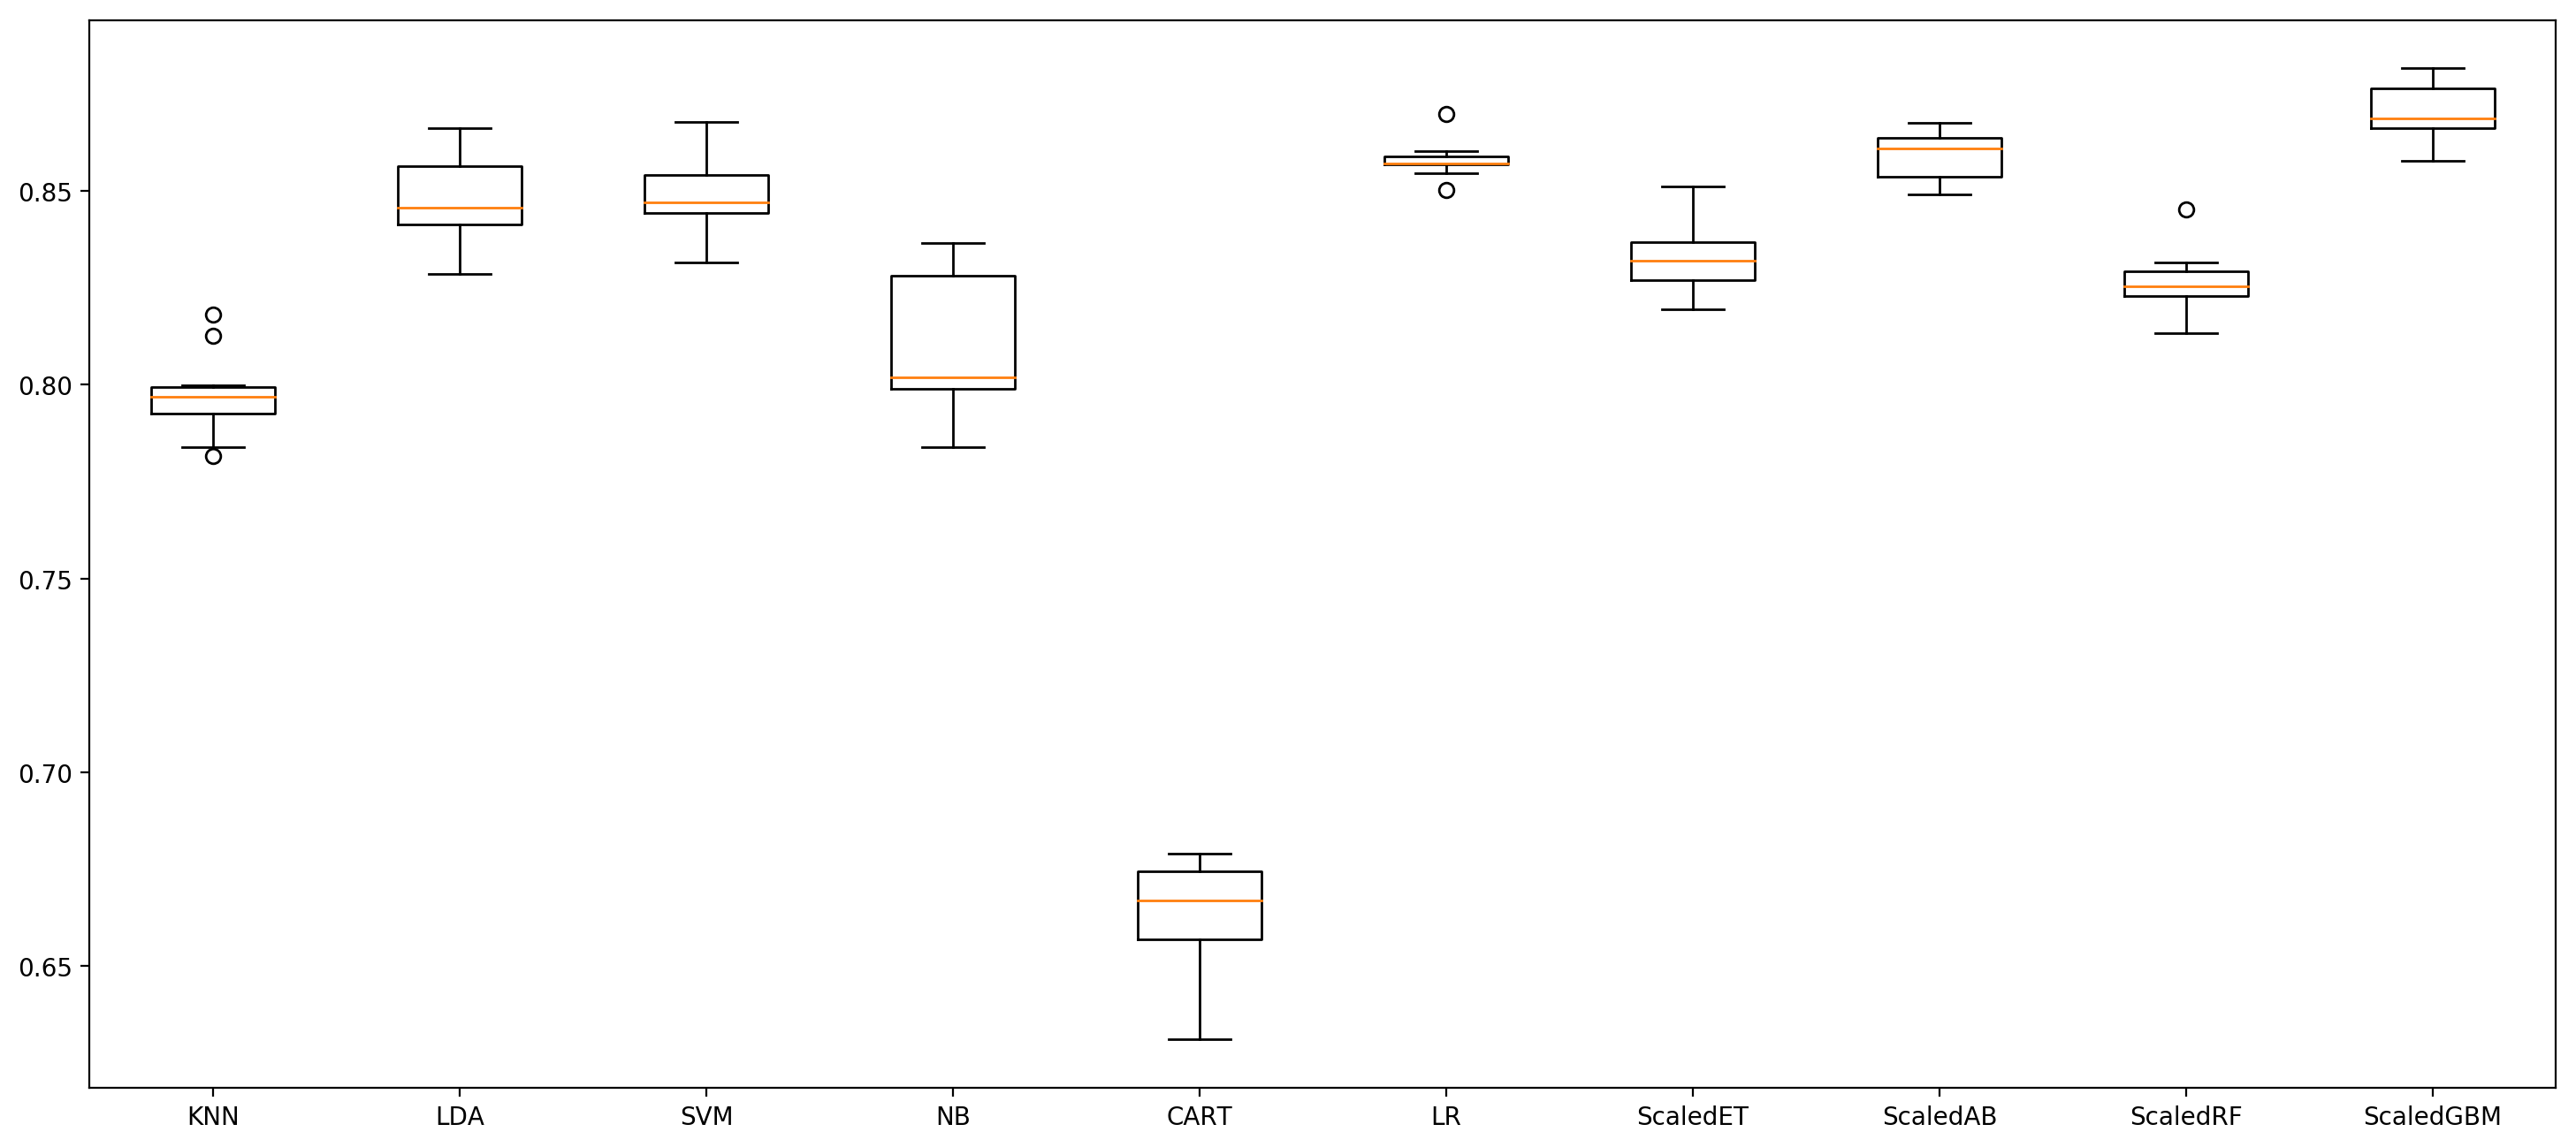

In [371]:
algorithm(X_ta,y_ta,"roc_auc")

KNN: 0.523274 (0.018242)
LDA: 0.531377 (0.024805)
SVM: 0.497368 (0.027980)
NB: 0.524985 (0.021864)
CART: 0.485977 (0.013690)
LR: 0.540452 (0.021251)
ScaledET: 0.494941 (0.014988)
ScaledAB: 0.584184 (0.015446)
ScaledRF: 0.486497 (0.031532)
ScaledGBM: 0.585561 (0.018705)


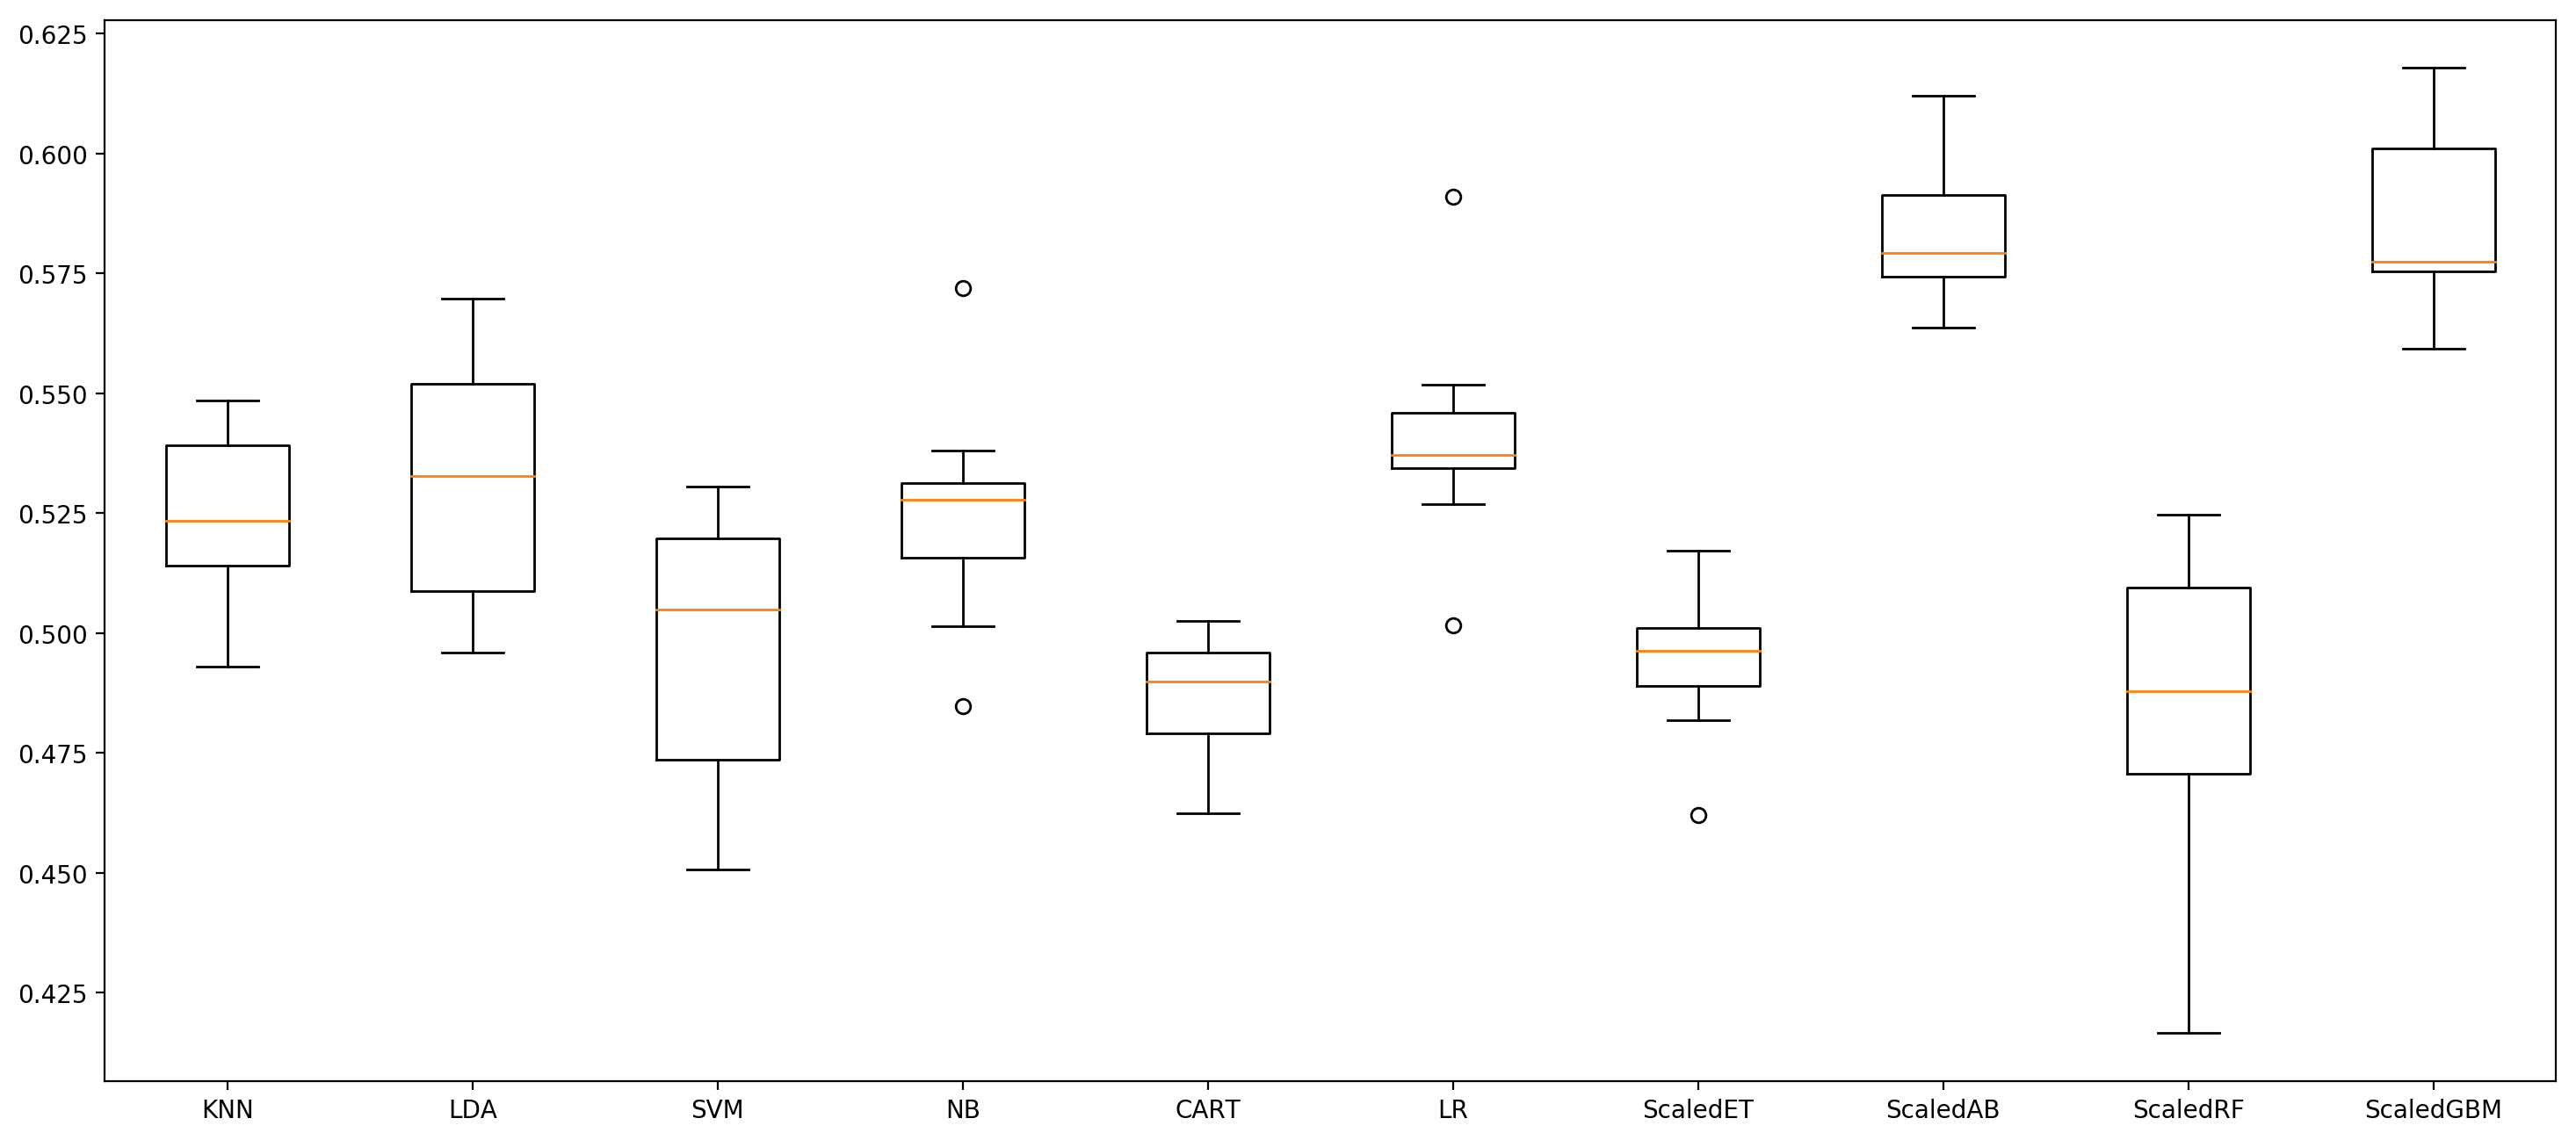

In [246]:
algorithm(X_ta,y_ta,"f1")

### 看来提升算法的效果是最好的
### auc和f1都显示标准化梯度提升树的分数是最高的，我们用这个模型跑一下数据看看

In [245]:
GBM = Pipeline([('Scaler',StandardScaler()),('GBM',GradientBoostingClassifier())])
GBM.fit(X_ta,y_ta)
predict_y_add = GBM.predict(t_X_add)
# 将模型预测结果增加到原数据里面
data_new['predict'] = predict_y_add
data_new.to_csv('./07241.csv')

Pipeline(memory=None,
     steps=[('Scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('GBM', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decreas...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))])

GaussianNB(priors=None)

<img src="./07242.png" />

#### 虽然recall分值没有贝叶斯分类器的高，但是第二类错误从之前的63.7%降低到了8.2%

<img src='./07243.png' style="float:left;" />

#### <span style="color:red">从上图可以看出，在预测高分段（1~6分）的用户，预测流失的准确性很低，但是7分（玩牌低、付费中）的用户预测流失分值比较高，高分段中预测不太准确的是5分和6分，我们找一下这些预测不准的用户有什么特征</span>

#### 我们发现流失用户的特征是7日玩牌分值比30日玩牌分值下降的那些用户，所以玩牌分值变化也可以作为一个特征加入到模型中去
我们增加一个特征：玩牌分值变化（play_score_alteration）,计算公式为$${play\_score\_alteration}=\frac{play\_passion\_30days-play\_passion\_7days}{play\_passion\_30days}$$

In [258]:
# 由于表中已经有相应的数据，我们用python直接计算出这个字段
play_passion_30days = data_new['play_passion_30days']
play_passion_7days = data_new['play_passion_7days']
play_score_alteration = (play_passion_30days-play_passion_7days)/play_passion_30days
data_new['play_score_alteration']= play_score_alteration
#data_new.head(10)

In [255]:
array_add= data_new.values
X_add_1 = array_add[:,3:53].astype(np.float32)
y_add = array_add[:,2].astype(np.float32)
# 调整数据尺度
transformer = MinMaxScaler(feature_range=(0,1))
t_X_add_1 = transformer.fit_transform(X_add_1)

In [256]:
validation_size = 0.2
seed = 7
X_ta1,X_va1,y_ta1,y_va1 = train_test_split(t_X_add_1,y_add,test_size=validation_size,random_state=seed)

KNN: 0.802487 (0.011585)
LDA: 0.847064 (0.011518)
SVM: 0.848540 (0.009698)
NB: 0.808648 (0.018262)
CART: 0.667385 (0.014855)
LR: 0.858538 (0.004962)
ScaledET: 0.821803 (0.011684)
ScaledAB: 0.858052 (0.007478)
ScaledRF: 0.823754 (0.012102)
ScaledGBM: 0.870132 (0.006293)


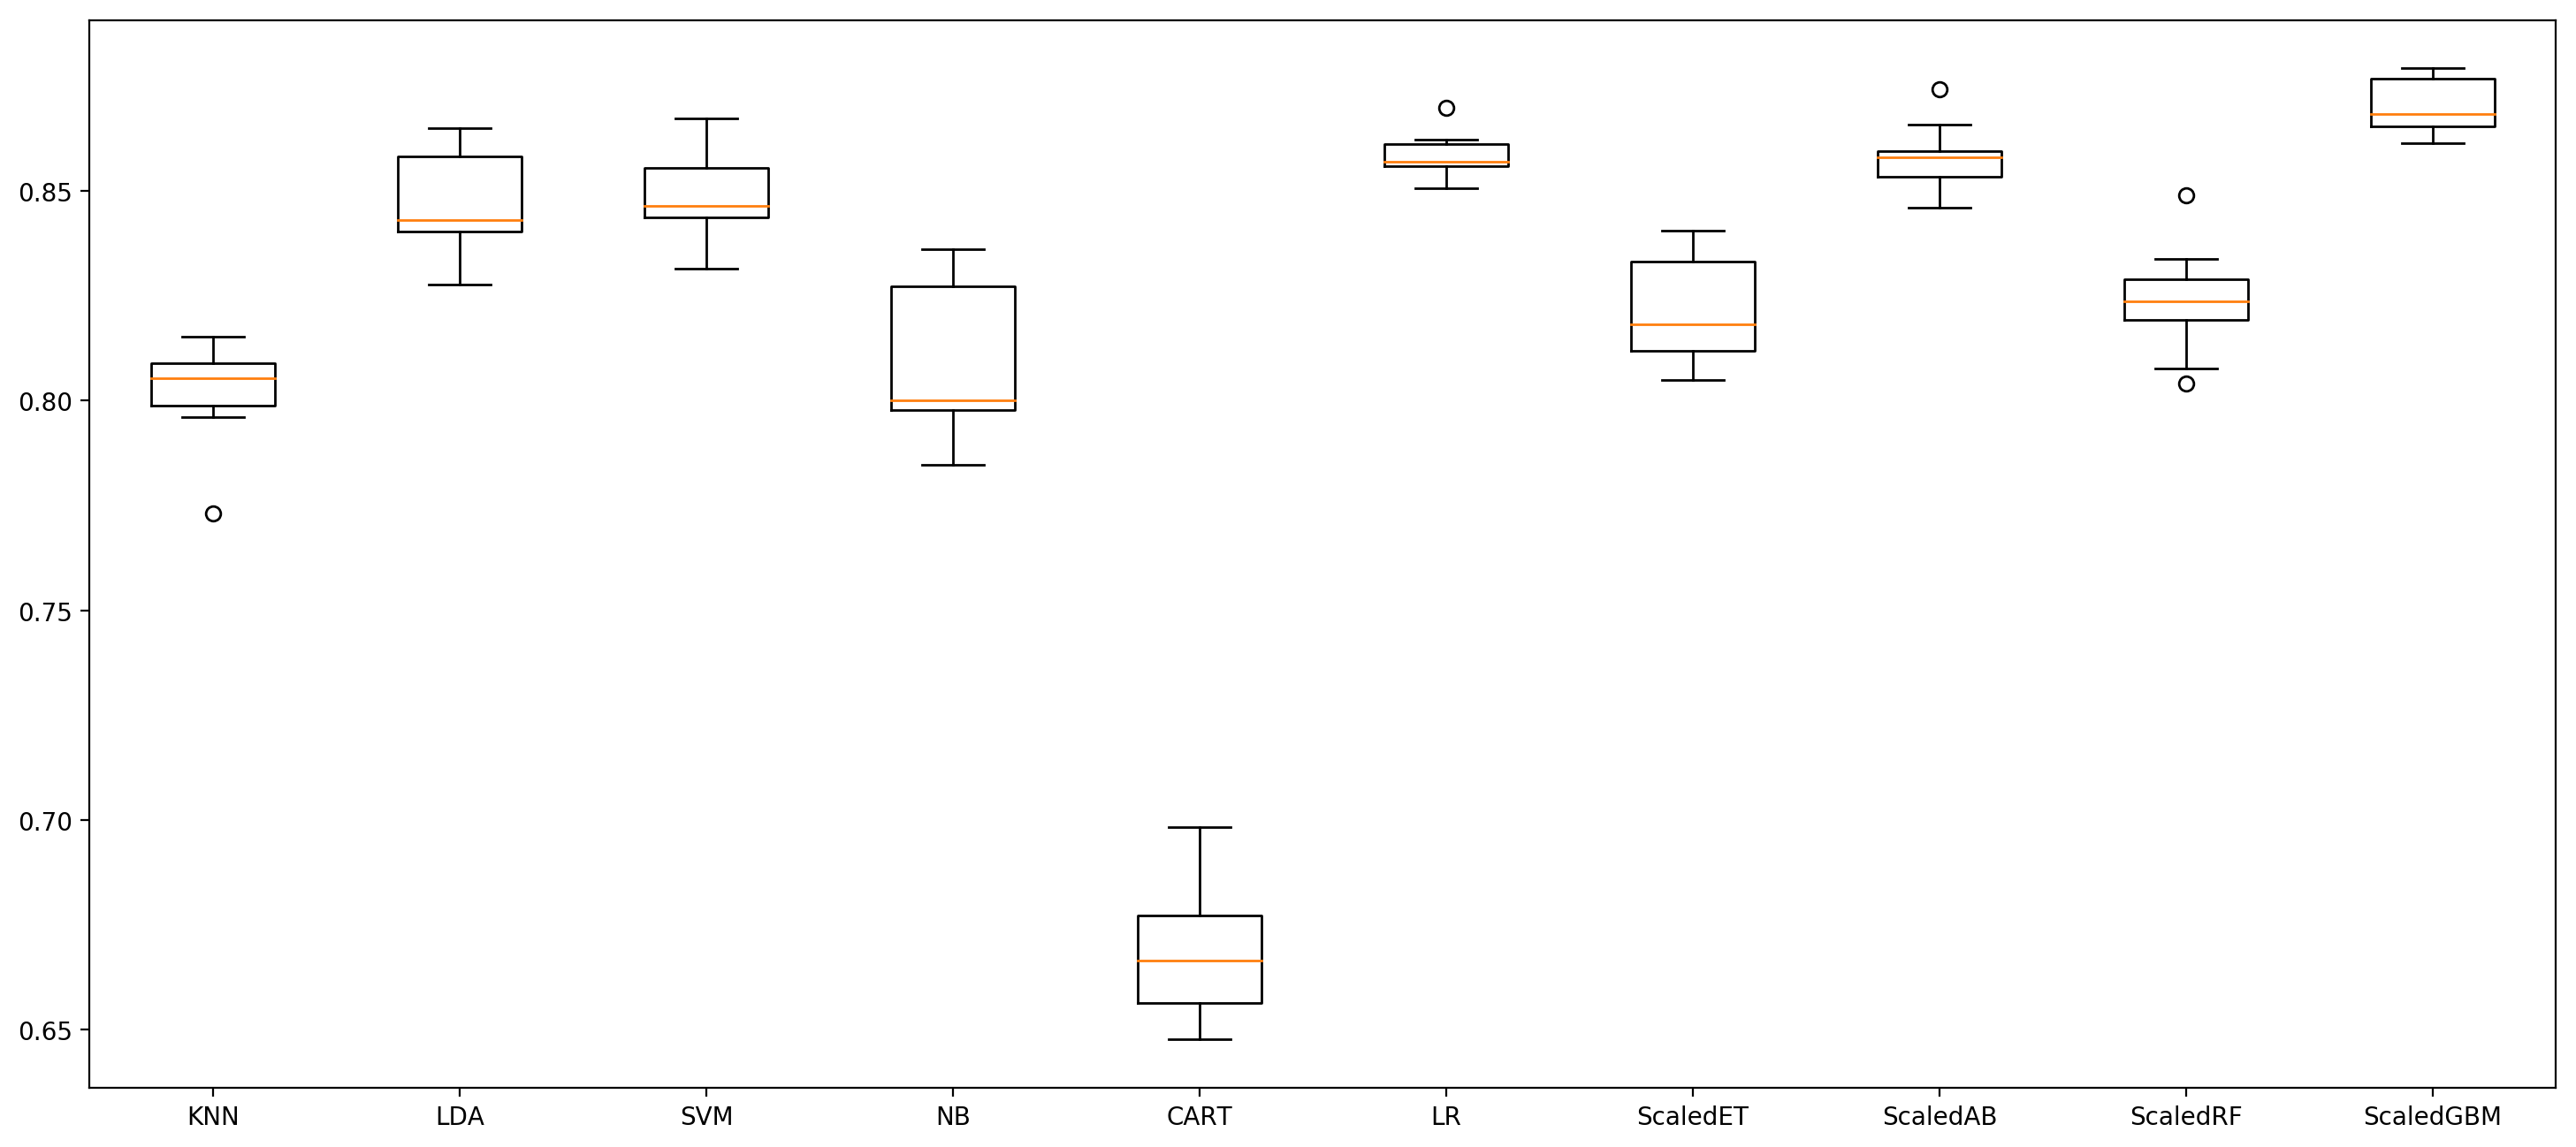

In [257]:
algorithm(X_ta1,y_ta1,"roc_auc")

#### 部分模型的得分高了一下，但是得分最高的梯度提升树并没有提升，我们还是把数据跑出来看看

In [267]:
GBM.fit(X_ta1,y_ta1)
predict_y_add = GBM.predict(t_X_add_1)
# 将模型预测结果增加到原数据里面
data_new['predict'] = predict_y_add
data_new.to_csv('./07242.csv')

Pipeline(memory=None,
     steps=[('Scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('GBM', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decreas...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))])

<img src="./07244.png" />

#### 对比之前的结果，预测流失正确的比例增加了，虽然只有一点点，但是证明增加的特征是有效果滴~
但是分值在5和6的用户，预测结果还是不理想。通过观察这些用户的特征，发现流失的用户并没有显著的特征  
由于数据是7月2日的，是不是这部分用户只是那周不想玩，然而并没有流失  
我们在7月25日再次查询一下这些当时流失的用户的最后登录时间，<b>发现有44%的用户又回流了</b>  
那我们顺便检验一下其他分值段没有预测到流失的用户的回流比例是多少（1~8分的），<b>结果显示，比例是45.5%</b>
#### 棋牌游戏本身就包含很多不确定因素，用户可能这周就是不想玩，突然有空了，然后又重新玩，他们并没有流失，只是那一周不活跃而已
顺便说一下，准确预测为流失，并且未回流的比例是45%┓( ´∀` )┏  
#### 预测正确并且未回流的比例为<span style="color:red">71.8%</span>（实际流失且未回流：370，预测成功266）

### 目前特征数有50个，我们减少一些特征试试

### 利用卡方检验选择特征值

In [306]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


def selectfeature(funcname,k,X,y):
    X_new = SelectKBest(funcname,k=k).fit_transform(X,y)
    a = X_new[0,:]
    b = a.tolist()
    c = names.tolist()
    features = DataFrame(sorted(zip(b,c),reverse=True))
    return features
# 选择相关性最高的20个特征,用卡方检验
chi2 = selectfeature(chi2,20,t_X_add_1,y_add)

### 递归特征消除（RFE）

In [294]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
rfe = RFE(estimator=lr,n_features_to_select=30)
rfe.fit(t_X_add_1,y_add)
# 选中的特征重要程度为1
RFE = DataFrame(sorted(zip(rfe.ranking_,names)))
rfe = RFE[RFE[0]==1]
rfe


RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
  n_features_to_select=30, step=1, verbose=0)

,0,1
0,1,bankrupt_count_7day
1,1,carrying_gold_bar
2,1,carrying_silver_coin
3,1,label_score
4,1,last_active_to_now_days
5,1,latest_play_coins_lose
6,1,lifespan
7,1,login_count_life
8,1,match_innings_life
9,1,play_duration_30day


### Lasso选择参数

In [296]:
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel

clf = LassoCV()
sfm = SelectFromModel(clf,threshold=0.01)
X_new = sfm.fit(X_ta1,y_ta1)
n_features = sfm.transform(X_va1)
lasso = DataFrame(sorted(zip(n_features[0,:],names),reverse=True))
lasso = lasso.iloc[0:20]
lasso

,0,1
0,1.000000,pay_sum_30day
1,1.000000,label_score
2,0.535571,lifespan
3,0.431090,pay_count_life
4,0.408800,play_duration_7day
5,0.333333,win_rate_7day
6,0.119092,play_innings_30day
7,0.063033,win_innings_life
8,0.039542,safebox_gold_bar
9,0.030621,win_rate_life


### L1特征选择

In [303]:
from sklearn.svm import LinearSVC
lsvc = LinearSVC(C=0.1, penalty="l1", dual=False).fit(X_ta1,y_ta1)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X_va1)
a = X_new[0,:]
l1 = DataFrame(sorted(zip(a,names),reverse=True))
l1

,0,1
0,1.000000,play_innings_7day
1,1.000000,play_innings_30day
2,1.000000,label_score
3,0.538255,signup_to_now_days
4,0.535571,lifespan
5,0.431090,if_vip
6,0.408800,total_gold_bar
7,0.333333,safebox_gold_bar
8,0.119092,carrying_gold_bar
9,0.000000,total_silver_coin


### 树选择特征

In [304]:
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier()
clf = clf.fit(X_ta1,y_ta1)
etc = DataFrame(sorted(zip(clf.feature_importances_ ,names),reverse=True))
etc = etc.iloc[0:20]
etc

,0,1
0,0.130331,last_active_to_now_days
1,0.036714,play_duration_30day
2,0.031742,login_count_7day
3,0.027315,lose_innings_7day
4,0.023478,win_rate_life
5,0.023461,win_innings_life
6,0.023335,win_innings_7day
7,0.023186,login_count_life
8,0.021349,play_innings_life
9,0.021335,play_innings_30day


## 将每个方法选择的特征组合起来

In [307]:
pd.concat([chi2,rfe,lasso,etc,l1],axis=1 )

,0,1,0,1,0,1,0,1,0,1
0,0.875000,lose_innings_7day,1,bankrupt_count_7day,1.000000,pay_sum_30day,0.130331,last_active_to_now_days,1.000000,play_innings_7day
1,0.875000,label_score,1,carrying_gold_bar,1.000000,label_score,0.036714,play_duration_30day,1.000000,play_innings_30day
2,0.500000,win_innings_life,1,carrying_silver_coin,0.535571,lifespan,0.031742,login_count_7day,1.000000,label_score
3,0.163265,lose_innings_life,1,label_score,0.431090,pay_count_life,0.027315,lose_innings_7day,0.538255,signup_to_now_days
4,0.046494,play_innings_life,1,last_active_to_now_days,0.408800,play_duration_7day,0.023478,win_rate_life,0.535571,lifespan
5,0.046494,play_innings_30day,1,latest_play_coins_lose,0.333333,win_rate_7day,0.023461,win_innings_life,0.431090,if_vip
6,0.040000,win_innings_7day,1,lifespan,0.119092,play_innings_30day,0.023335,win_innings_7day,0.408800,total_gold_bar
7,0.026548,total_silver_coin,1,login_count_life,0.063033,win_innings_life,0.023186,login_count_life,0.333333,safebox_gold_bar
8,0.025497,carrying_gold_bar,1,match_innings_life,0.039542,safebox_gold_bar,0.021349,play_innings_life,0.119092,carrying_gold_bar
9,0.016476,play_duration_30day,1,play_duration_30day,0.030621,win_rate_life,0.021335,play_innings_30day,0.000000,total_silver_coin


### 暂时选定的特征为：
* label_score
* total_silver_coin
* carrying_gold_bar
* carrying_silver_coin	
* signup_to_now_days
* total_gold_bar
* safebox_silver_coin
* lifespan
* lose_innings_7day
* win_innings_life	
* lose_innings_life
* play_innings_life
* play_innings_30day
* win_innings_7day
* play_duration_30day
* safebox_gold_bar	
* play_duration_life
* play_innings_7day
* play_duration_7day
* bankrupt_count_7day
* last_active_to_now_days
* latest_play_coins_lose	
* login_count_life

## 测试一下模型

In [308]:
select_X_1 = data[["label_score","total_silver_coin","carrying_gold_bar","carrying_silver_coin","signup_to_now_days","total_gold_bar","safebox_silver_coin","lifespan","lose_innings_7day","win_innings_life","lose_innings_life","play_innings_life","play_innings_30day","win_innings_7day","play_duration_30day","safebox_gold_bar","play_duration_life","play_innings_7day","play_duration_7day","bankrupt_count_7day","last_active_to_now_days","latest_play_coins_lose","login_count_life"]].values
select_X_transform = transformer.fit_transform(select_X_1)
validation_size = 0.2
seed = 7
select_X_t1,select_X_v1,select_y_t1,select_y_v1 = train_test_split(select_X_transform,y,test_size=validation_size,random_state=seed)

KNN: 0.799099 (0.013446)
LDA: 0.834059 (0.013035)
SVM: 0.837104 (0.011886)
NB: 0.806800 (0.012635)
CART: 0.656491 (0.020645)
LR: 0.845150 (0.004861)
ScaledET: 0.817815 (0.008064)
ScaledAB: 0.849320 (0.006782)
ScaledRF: 0.822923 (0.007095)
ScaledGBM: 0.863365 (0.007412)


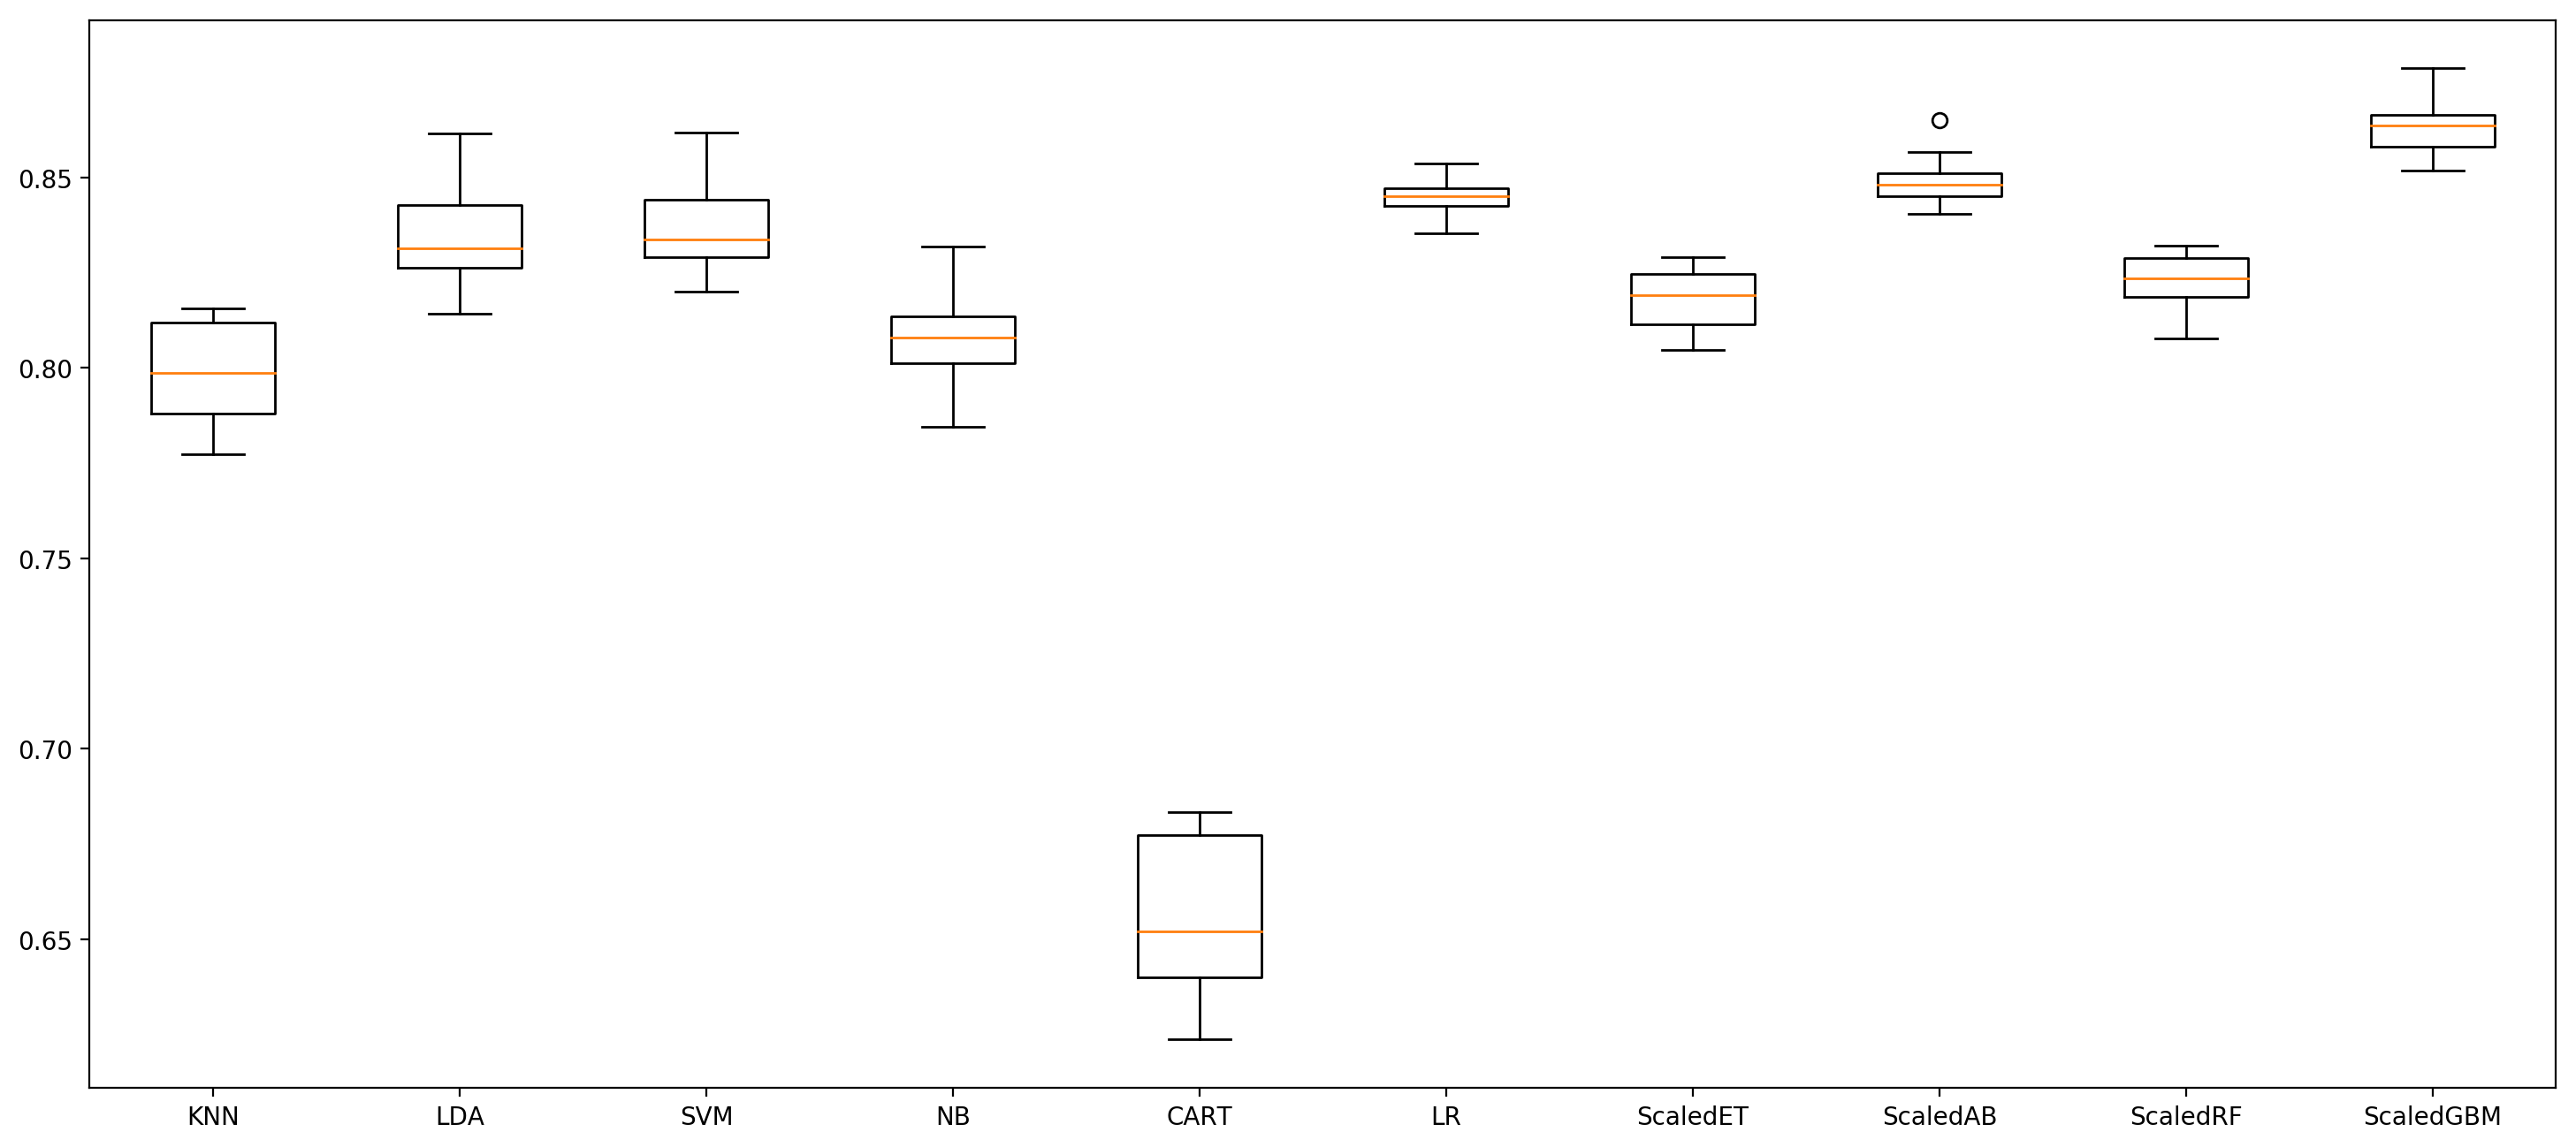

In [313]:
algorithm(select_X_t1,select_y_t1,"roc_auc")

In [321]:
GBM.fit(select_X_t1,select_y_t1)
cross_val_score(GBM, select_X_t1,select_y_t1, scoring='roc_auc').mean()

Pipeline(memory=None,
     steps=[('Scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('GBM', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decreas...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))])

0.86301510134053938

In [320]:
predict_y_add = GBM.predict(select_X_transform)
# 将模型预测结果增加到原数据里面
data_new['predict'] = predict_y_add
data_new.to_csv('./07245.csv')

#### 结果相比全部特征少预测对了流失的用户有80个用户，所以如果可以的话，还是选择全部特征做预测会比较好

## 特征工程的事我们就先这样，我们来优化一下GBM的参数，看看能不能再进一步提升准确度
#### GBM（随机梯度提升树）的原理是：
> 要找到某个函数的最大值，最好的办法就是沿着该函数的梯度方向探寻。梯度算子总是指向函数值增长最快的方向。随机梯度指的是一次只用一个样本点来更新回归函数。

对应的参数及含义：
* loss：损失函数
* learning_rate:学习率，默认0.1，较低的通常有较好的拟合效果，但是效率会降低
* n_estimators: 基学习器的个数，也就是树的颗数。当学习率不变时，较多的基学习期会带来过拟合的风险，默认为100
* max_depth：树的深度，默认为3,限制了单颗树的节点
* criterion：标准。默认为friedman_mse，这个默认的一般来说就是最好的啦
* min_samples_split：最小可分样本数，即到达某节点时，确定是否需要再分下去，如果这个节点的样本数小于阈值，则停止分裂。默认为2。如果是整数，那么就是这个数；如果是浮点数，那么就是百分比
* min_samples_leaf：最小叶节点样本数，相当于剪枝，默认为1，和上面的一样，也有整数和百分比
* min_weight_fraction_leaf:与min_samples_leaf类似，但这里设置的不是样本数，而是整体样本的比例；
* subsample: 子采样百分比，参考随机森林，但是这里的抽样是不放回抽样，默认是1.0，通常取0.8左右
* max_features: 待分裂的特征数，默认为None，即=特征数。一般用log2
    * int：就是这个数
    * float：百分比
    * auto/sqrt：$\sqrt{features}$
    * log2:$\log2$
* max_leaf_nodes: 树的叶节点数。如果设置这个，那么max_depth会被忽略，默认为None
* init: 模型变量，即GBM的启动模型，默认为None
* verbose：决定日志（训练过程）是否需要打印，默认不打印；
* warm_start：即热启动，当你训练GBM到一定程度停止时，如果你想在这个基础上接着训练，就需要用到该参数（True）减少重复训练；
* random_state：随机状态参数，即随机种子；当调参时，该参数需固定，否则根据CV的调参会产生影响；
* presort ：预先分类，决定是否要预先分类数据用来加速找到最优分类，默认为auto

In [429]:
def plot_param_curve(plt, train_sizes, cv_results, xlabel):
    train_scores_mean = cv_results['mean_train_score']
    train_scores_std = cv_results['std_train_score']
    test_scores_mean = cv_results['mean_test_score']
    test_scores_std = cv_results['std_test_score']
    plt.title('parameters turning')
    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel('score')
    plt.fill_between(train_sizes, 
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, 
                     alpha=0.1, color="r")
    plt.fill_between(train_sizes, 
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, 
                     alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, '.--', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, '.-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [469]:
# 采用网格搜索优化参数
# 我们还是采用全部特征进行训练
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [495]:
def plot_param_curve_GBM(paramname,data,score):
    param_learning_rate= {paramname:data}
    clf = GridSearchCV(estimator=model,param_grid=param_learning_rate,scoring=score);
    clf.fit(X_ta1,y_ta1)
    print("best params:{0}\nbest score:{1}".format(clf.best_params_,clf.best_score_))
    plt.figure(figsize=(10,4),dpi=144)
    plot_param_curve(plt,data,clf.cv_results_,xlabel=paramname)

best params:{'learning_rate': 0.12}
best score:0.584532158735


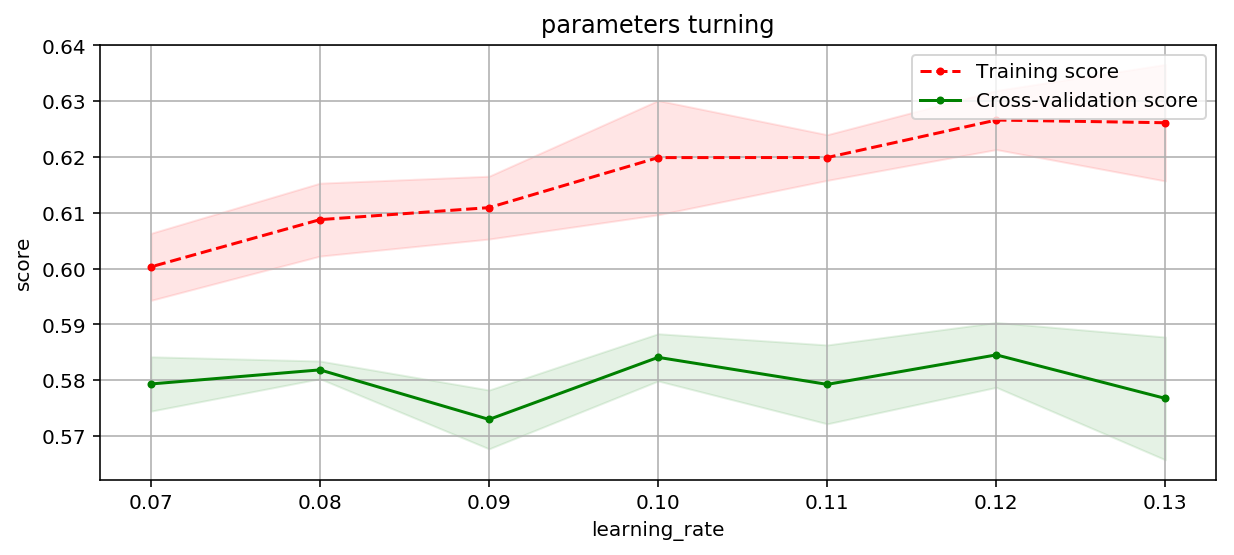

In [501]:
plot_param_curve_GBM('learning_rate',[0.13,0.12,0.11,0.1,0.09,0.08,0.07],"f1")

best params:{'learning_rate': 0.1}
best score:0.536435658915


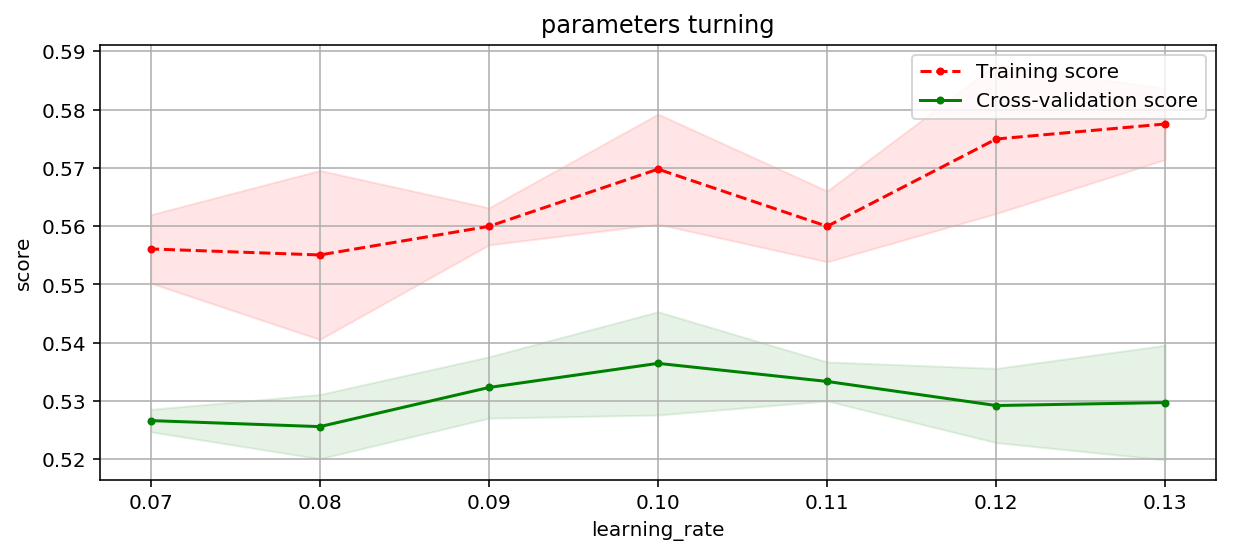

In [500]:
plot_param_curve_GBM('learning_rate',[0.13,0.12,0.11,0.1,0.09,0.08,0.07],"recall")

best params:{'learning_rate': 0.09}
best score:0.641227750554


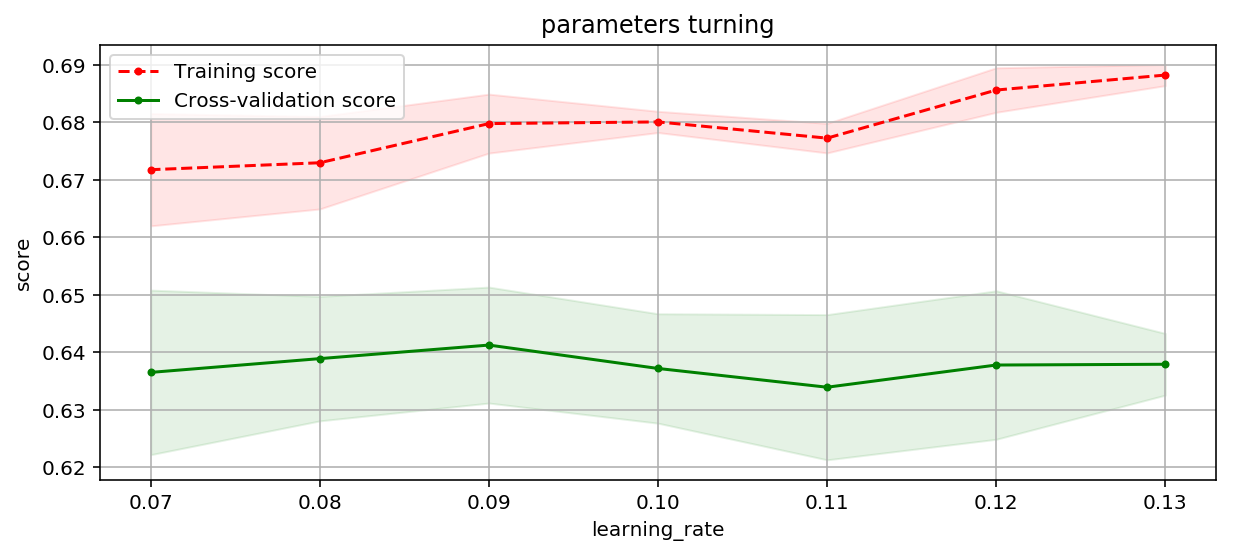

In [502]:
plot_param_curve_GBM('learning_rate',[0.13,0.12,0.11,0.1,0.09,0.08,0.07],"precision")

best params:{'learning_rate': 0.13}
best score:0.868872513641


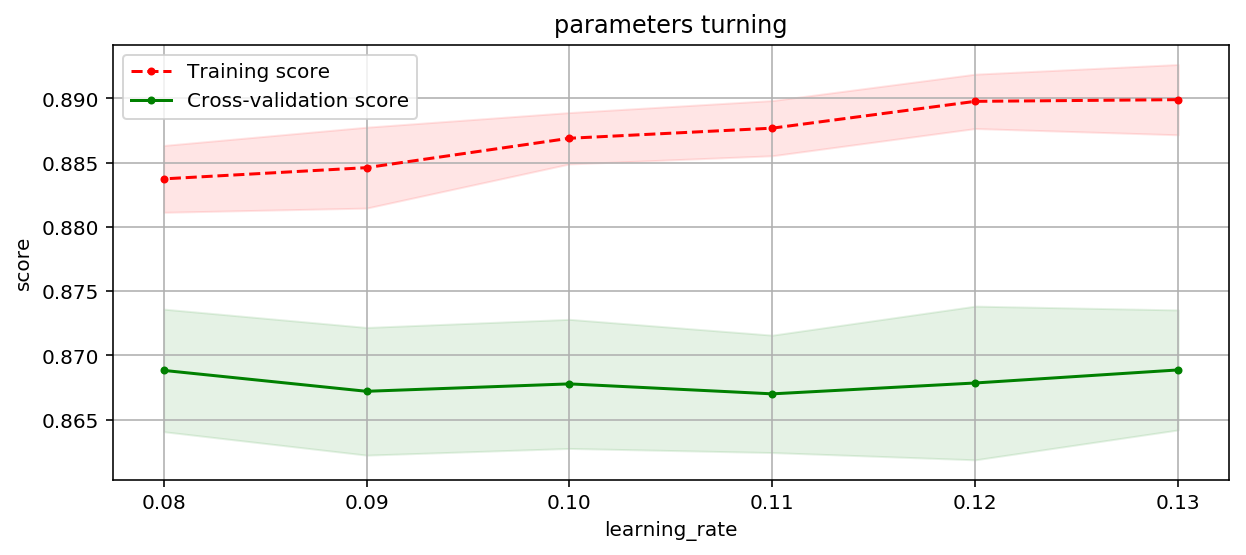

In [504]:
plot_param_curve_GBM('learning_rate',[0.13,0.12,0.11,0.1,0.09,0.08],"roc_auc")

best params:{'n_estimators': 110}
best score:0.53746744186


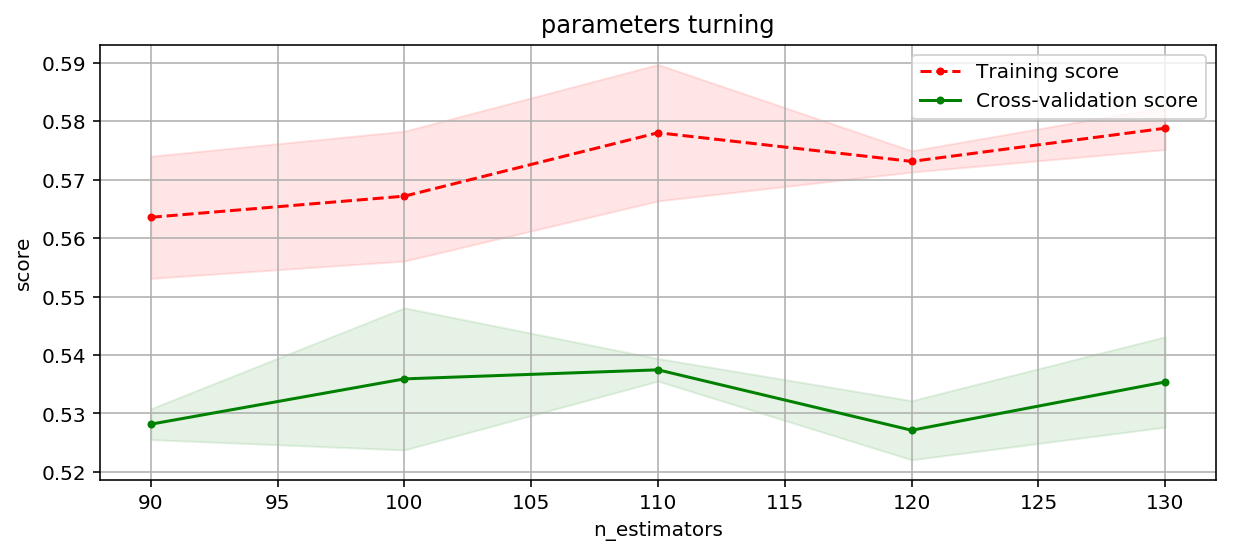

In [509]:
plot_param_curve_GBM('n_estimators',[90,100,110,120,130],"recall")

best params:{'max_depth': 4}
best score:0.536434883721


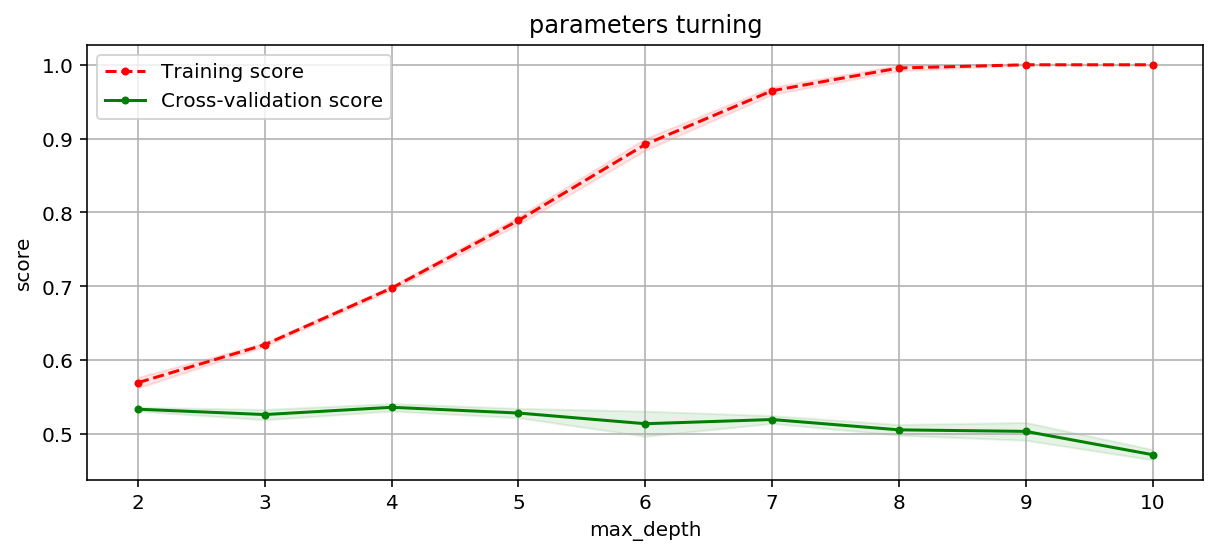

In [508]:
plot_param_curve_GBM('max_depth',[2,3,4,5,6,7,8,9,10],"recall")

best params:{'subsample': 0.9}
best score:0.537469379845


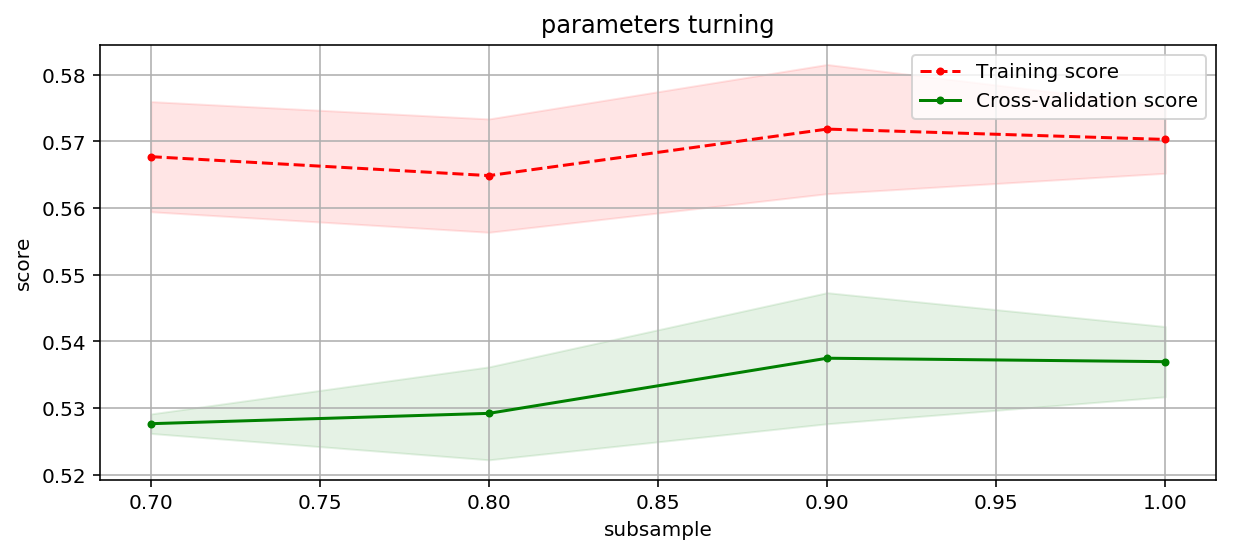

In [510]:
plot_param_curve_GBM('subsample',[0.7,0.8,0.9,1],"recall")

best params:{'max_features': 'auto'}
best score:0.555555620155


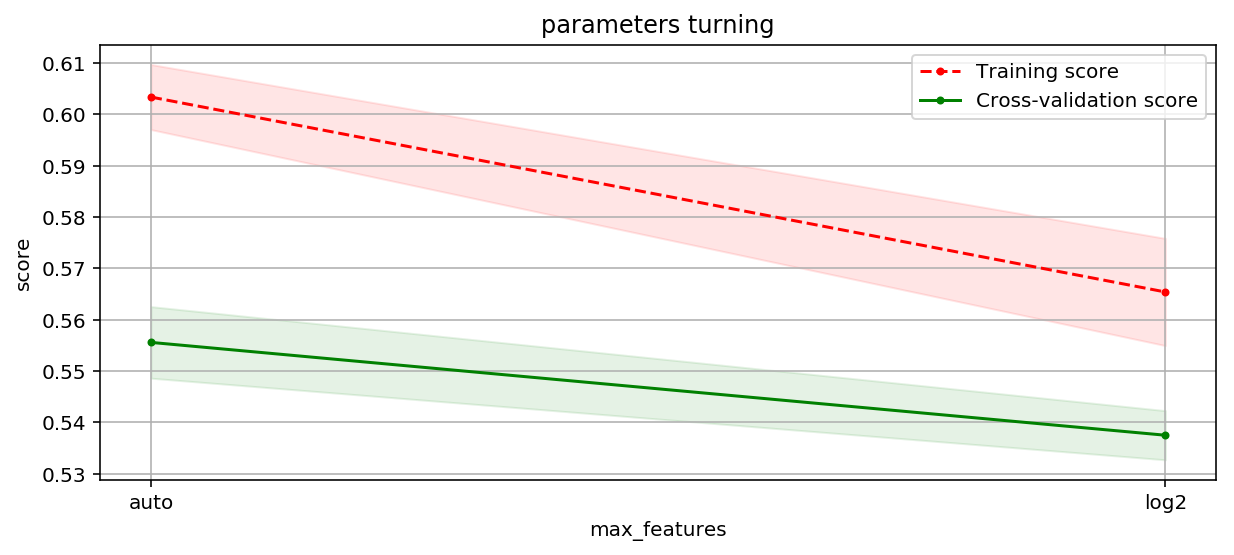

In [511]:
plot_param_curve_GBM('max_features',['auto','log2'],"recall")

In [ ]:
model = GradientBoostingClassifier()
param_learning_rate= {'learning_rate':[0.1,0.12,0.13],
                      'n_estimators':[90,100,110,120,130],
                      'max_depth':[2,3,4,5,6,7,8,9,10],
                     'subsample':[0.7,0.8,0.9,1]}
                
clf = GridSearchCV(estimator=model,param_grid=param_learning_rate,scoring="recall");
clf.fit(X_ta1,y_ta1)
print("best params:{0}\nbest score:{1}".format(clf.best_params_,clf.best_score_))
plt.figure(figsize=(10,4),dpi=144)
plot_param_curve(plt,data,clf.cv_results_,xlabel=paramname)

## 呦西，现在我们get到了所有最优的参数组合，来试试把

In [525]:
model = GradientBoostingClassifier(
learning_rate=0.1,
max_depth=4,
subsample=0.9
)
model.fit(X_ta1,y_ta1)

default_model = GradientBoostingClassifier()
default_model.fit(X_ta1,y_ta1)

pipelineGBM =Pipeline([('Scaler',StandardScaler()),('GBM',model)])
pipelineGBM.fit(X_ta1,y_ta1)

default_pipelineGBM =Pipeline([('Scaler',StandardScaler()),('GBM',default_model)])
default_pipelineGBM.fit(X_ta1,y_ta1)

print("best params:%.4f"%cross_val_score(model,X_va1,y_va1, scoring='recall').mean())
print("default params:%.4f"%cross_val_score(default_model,X_va1,y_va1, scoring='recall').mean())
print("pipeline best params:%.4f"%cross_val_score(pipelineGBM,X_va1,y_va1, scoring='recall').mean())
print("pipeline default params:%.4f"%cross_val_score(default_pipelineGBM,X_va1,y_va1, scoring='recall').mean())

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=0.9, verbose=0,
              warm_start=False)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

Pipeline(memory=None,
     steps=[('Scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('GBM', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decreas...      presort='auto', random_state=None, subsample=0.9, verbose=0,
              warm_start=False))])

Pipeline(memory=None,
     steps=[('Scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('GBM', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decreas...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))])

best params:0.5123
default params:0.4810
pipeline best params:0.5034
pipeline default params:0.4832


### 结果显示进行了参数优化的无标准化梯度提升树的结果是最好的
#### 我们还是导出数据看看

In [526]:
best_model = GradientBoostingClassifier(
learning_rate=0.1,
max_depth=4,
subsample=0.9
)
best_model.fit(X_ta1,y_ta1)
predict_y_add1 = best_model.predict(t_X_add_1)
data_new['predict'] = predict_y_add1
data_new.to_csv('./0727_best_model.csv')

default_model = GradientBoostingClassifier()
default_model.fit(X_ta1,y_ta1)
predict_y_add2 = default_model.predict(t_X_add_1)
data_new['predict'] = predict_y_add2
data_new.to_csv('./0726_default_model.csv')

pipelineGBM =Pipeline([('Scaler',StandardScaler()),('GBM',best_model)])
pipelineGBM.fit(X_ta1,y_ta1)
predict_y_add3 = pipelineGBM.predict(t_X_add_1)
data_new['predict'] = predict_y_add3
data_new.to_csv('./0726_pipelineGBM.csv')

default_pipelineGBM =Pipeline([('Scaler',StandardScaler()),('GBM',default_model)])
default_pipelineGBM.fit(X_ta1,y_ta1)
predict_y_add4 = pipelineGBM.predict(t_X_add_1)
data_new['predict'] = predict_y_add4
data_new.to_csv('./0726_default_pipelineGBM.csv')

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=0.9, verbose=0,
              warm_start=False)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

Pipeline(memory=None,
     steps=[('Scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('GBM', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decreas...      presort='auto', random_state=None, subsample=0.9, verbose=0,
              warm_start=False))])

Pipeline(memory=None,
     steps=[('Scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('GBM', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decreas...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))])

### 嗯，综合结果来看，调过参数并且没有经过正则化惩罚的GBM的效果是最好的

### 我们画出学习曲线看看

In [470]:
def plot_learning_curve(plt, estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o--', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<Figure size 1440x576 with 0 Axes>

<module 'matplotlib.pyplot' from 'c:\python27\lib\site-packages\matplotlib\pyplot.pyc'>

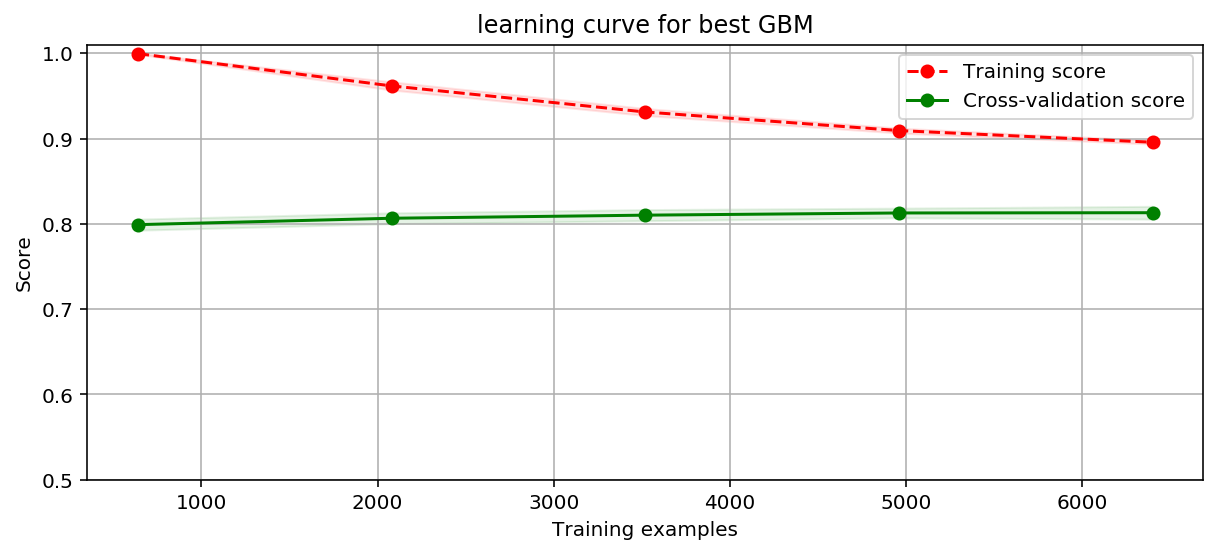

In [527]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
plt.figure(figsize=(10, 4), dpi=144)
title = "learning curve for best GBM"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(plt, best_model,
                    title, X_ta1,y_ta1, ylim=(0.5, 1.01), cv=cv)

In [531]:
# 画出roc-auc曲线
from sklearn.metrics import roc_curve, auc
def plot_roc_auc(model):
    y_score = model.fit(X_ta1,y_ta1).decision_function(X_va1)
    # Compute ROC curve and ROC area for each class
    fpr,tpr,threshold = roc_curve(y_va1, y_score) ###计算真正率和假正率
    roc_auc = auc(fpr,tpr) ###计算auc的值
     
    plt.figure()
    lw = 2
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

<Figure size 432x288 with 0 Axes>

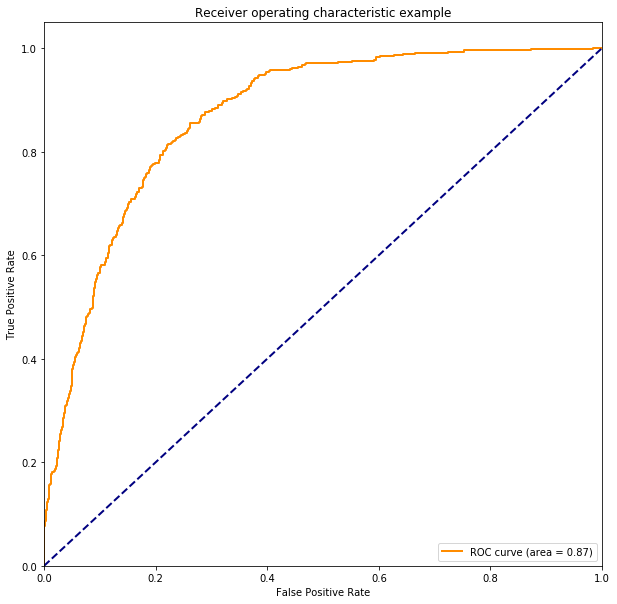

In [532]:
plot_roc_auc(best_model)

<Figure size 432x288 with 0 Axes>

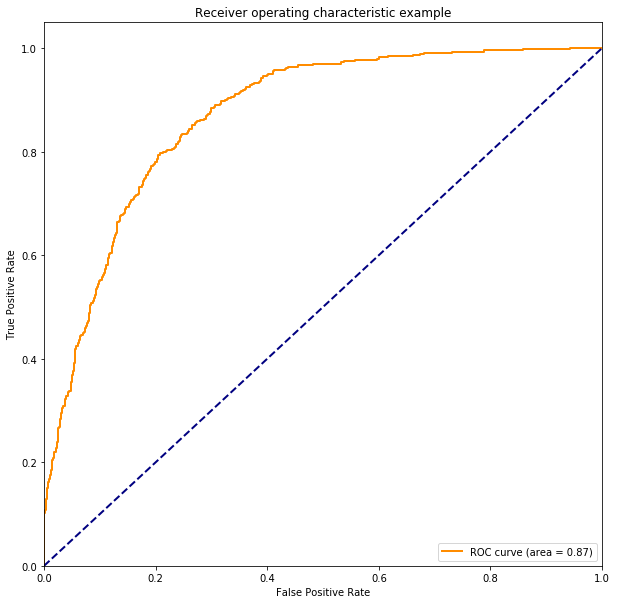

In [533]:
plot_roc_auc(pipelineGBM)

<Figure size 432x288 with 0 Axes>

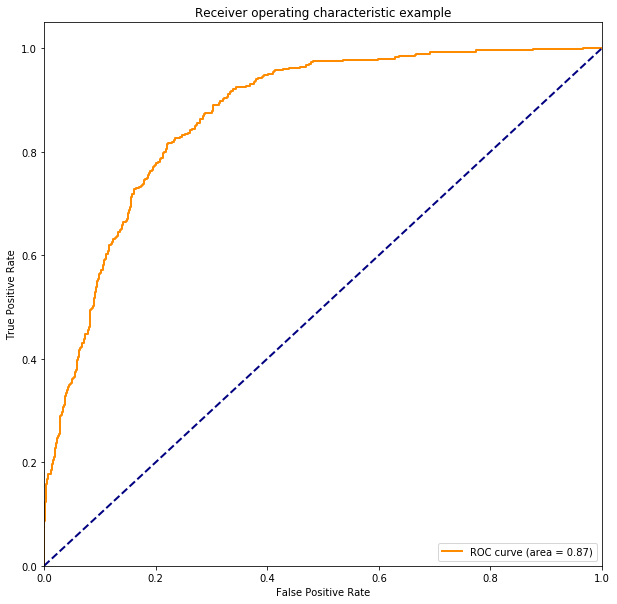

In [534]:
plot_roc_auc(default_model)

### 从学习曲线可以看出，增加数据量的收益有限

In [553]:
# 封装Sklearn的算法
from pickle import dump
def model(modelname,X,y,_param):
    if modelname == 'GBM':
        GBM = GradientBoostingClassifier(_param)
        GBM.fit(X,y)
        save_model = './csvs/'+modelname+'.sav'
        with open(save_model,'wb') as model_f:
            dump(GBM,model_f)
    elif modelname == 'AB':
        AB = AdaBoostClassifier(_param)
        AB.fit(X,y)
        save_model = './csvs/'+modelname+'.sav'
        with open(save_model,'wb') as model_f:
            dump(AB,model_f)

In [559]:
param = [learning_rate=0.1]
model('GBM',X_ta1,y_ta1,(learning_rate=0.1))

SyntaxError: invalid syntax (<ipython-input-559-117d68ab0572>, line 1)

In [560]:
import autosklearn.classification

ImportError: No module named autosklearn.classification

## 那关于梯度提升树的优化就到此为止，我们来优化一下AdaBoostClassifier
#### AdaBoost是一种迭代算法，其核心思想是针对同一个训练集